In [5]:
#IMPORT AND FUNCTIONS
# Import libraries and dependencies
import numpy as np
import pandas as pd
import hvplot.pandas
from pathlib import Path
import yfinance as yf
import matplotlib.pyplot as plt
import datetime
import math
import numpy as np
import tweepy 
import time
import seaborn as sns
import multiindex
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats 
import random
from scipy.optimize import minimize
import ipywidgets as widgets
from numpy import average

pd.set_option('display.max_columns', None)

#deactivate the warnings
import warnings
warnings.filterwarnings("ignore")

#data received through csv of yahoo finance with our portfolio
portfolio_path = "C:/Users/jacop/Downloads/quotes.csv"
portfolio_start = pd.read_csv(portfolio_path)

#in this file we need the stocks we don't own but we want to analyze
#it only needs the column "Symbol" with the tickers
new_stocks_path = "C:/Users/jacop/Downloads/quotes (1).csv"

#creating a list of tickers
my_ticks = list(portfolio_start["Symbol"].unique())


period = "2y"
interval = "1d"

#query to the Yahoo Finance API for all the stocks in the list 
#2 years, one value per day
df_list = [yf.download(tick, period = period, interval = interval) for tick in my_ticks]

#if our initial database doesn't include prices and quantity we automatically
#put the values to 1 to run the code
try:
   portfolio_start["Purchase Price"]
except KeyError:
   portfolio_start["Purchase Price"] = [1]*portfolio_start.shape[0]

try:
   portfolio_start["Quantity"]
except KeyError:
   portfolio_start["Quantity"] = [1]*portfolio_start.shape[0]


portfolio = pd.DataFrame(columns = ["Symbol", "Purchase Price", "Quantity"])
portfolio["Symbol"] = my_ticks

#since yahoo finance creates a line for every batch of stocks, we need to weight 
#the prices by the quantity to have a single line with all the holding per ticker
for tick in my_ticks:
    portfolio.loc[portfolio["Symbol"] == tick, "Purchase Price"] = round(
        average(portfolio_start.loc[portfolio_start["Symbol"] == tick, "Purchase Price"],
        weights = portfolio_start.loc[portfolio_start ["Symbol"] == tick,"Quantity"]),
                3)
    portfolio.loc[portfolio["Symbol"] == tick, "Quantity"] = sum(
        portfolio_start.loc[portfolio_start["Symbol"] == tick, "Quantity"])

    
#import SPY as a reference for the SP500 
#remember to keep the same period and interval
spy = yf.download("SPY", period = period, interval = interval)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [6]:
#Creation of variables and dataframes
total_portfolio = 0

#individual stocks new variables
for i in range(len(my_ticks)):
    df_list[i]["20 day mean"] = df_list[i]["Adj Close"].rolling(20).mean()
    df_list[i]["Upper"] = df_list[i]["20 day mean"] + 2*(df_list[i]["Adj Close"].rolling(20).std())
    df_list[i]["Lower"] = df_list[i]["20 day mean"] - 2*(df_list[i]["Adj Close"].rolling(20).std())
    df_list[i]["Daily Returns"] = (df_list[i]["Adj Close"]/df_list[i]["Adj Close"].shift(1))-1
    df_list[i]["Cumulative Daily Return"] = (1+ df_list[i]["Daily Returns"]).cumprod()
    total_portfolio += df_list[i]["Adj Close"].tail(1)*portfolio.loc[i,"Quantity"]

#calculation of the weights per stock
for i in range(len(my_ticks)):
    df_list[i]["Normed Return"] = df_list[i]["Adj Close"]/df_list[i].iloc[0]["Adj Close"] 
    portfolio.loc[i,"% of allocation"] = float(df_list[i]["Adj Close"].dropna().tail(1))*portfolio.loc[i,"Quantity"]/float(total_portfolio)

#creation of weighted total portfolio over time
for i in range(len(my_ticks)):
    df_list[i]["Allocation"]= df_list[i]["Normed Return"].dropna()*portfolio.loc[i,"% of allocation"]
    df_list[i]["Position Values"]=df_list[i]["Allocation"].dropna()*float(total_portfolio)
all_pos = [df["Position Values"].dropna() for df in df_list]
portfolio_df = pd.concat(all_pos, axis = 1)
portfolio_df.columns = my_ticks
portfolio_df = portfolio_df.dropna()
#portfolio new variables
portfolio_df["Total Position"] = portfolio_df.sum(axis=1)
portfolio_df["Daily Returns"] = portfolio_df["Total Position"].pct_change(1)
portfolio_df["Cumulative Daily Return"] = (1+ portfolio_df["Daily Returns"]).cumprod()
portfolio_df["20 day mean"] = portfolio_df["Total Position"].rolling(20).mean()
portfolio_df["Sortino Returns"] = 0
portfolio_df.loc[portfolio_df["Daily Returns"] < 0,"Sortino Returns"] = portfolio_df.loc[portfolio_df["Daily Returns"] < 0,"Daily Returns"]

#S&P500 reference
spy["Daily Returns"] = spy["Close"].pct_change(1)
spy["Cumulative Daily Return"] = (1+ spy["Daily Returns"]).cumprod()    


----------------------------------------------------------------



BABA
Last Price: 229.25 


Loss :   -102 $   -18 % 


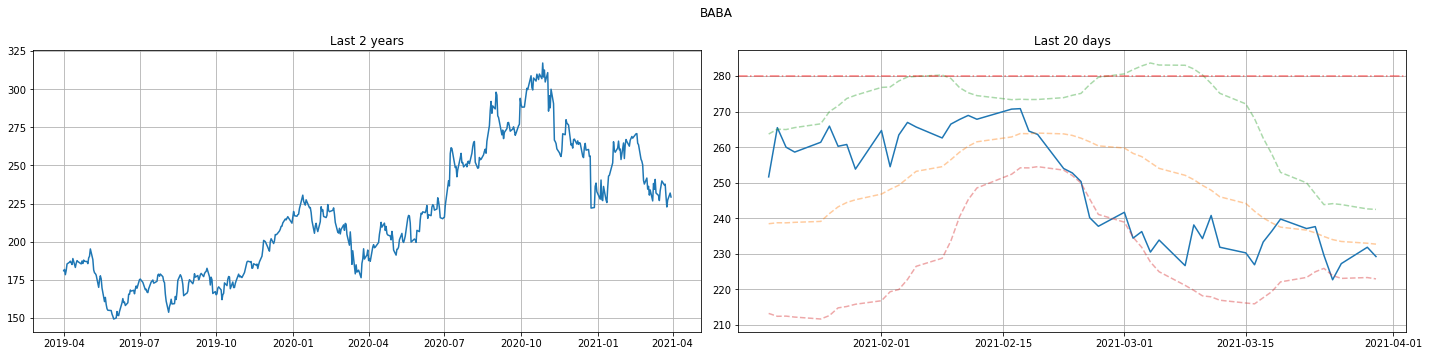


Beta:  0.35572   Alpha:  0.00056


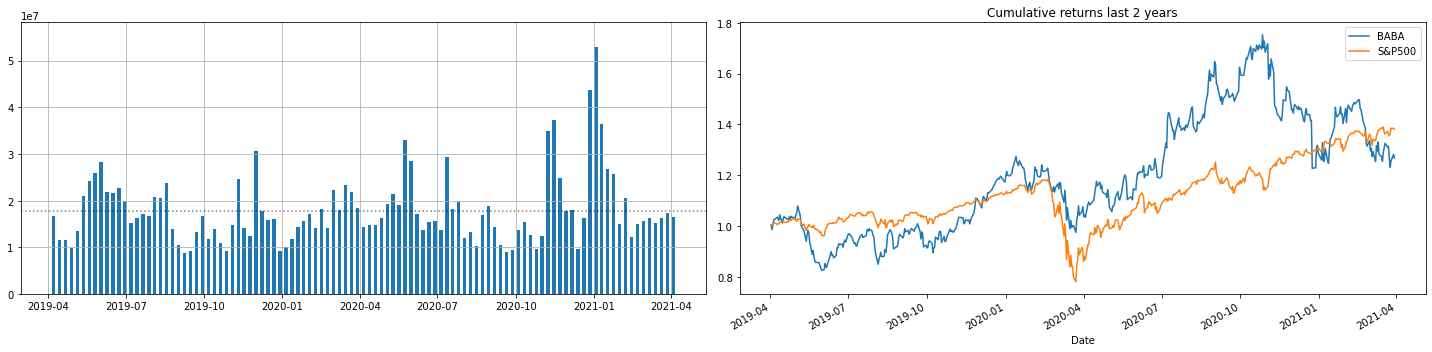

Mean Daily Return:  0.07 %
Annualized Return:  31.29 %

Mean Daily Return (last 20 days):  -0.08 %
Annualized Return (last 20 days):  -26.19 %


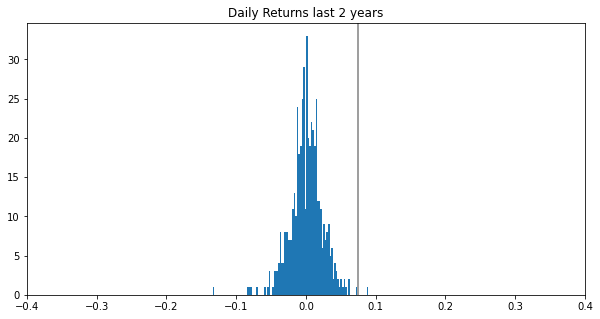


----------------------------------------------------------------



NVDA.MI
Last Price: 441.0 


Gain :   + 214 $   + 11 % 


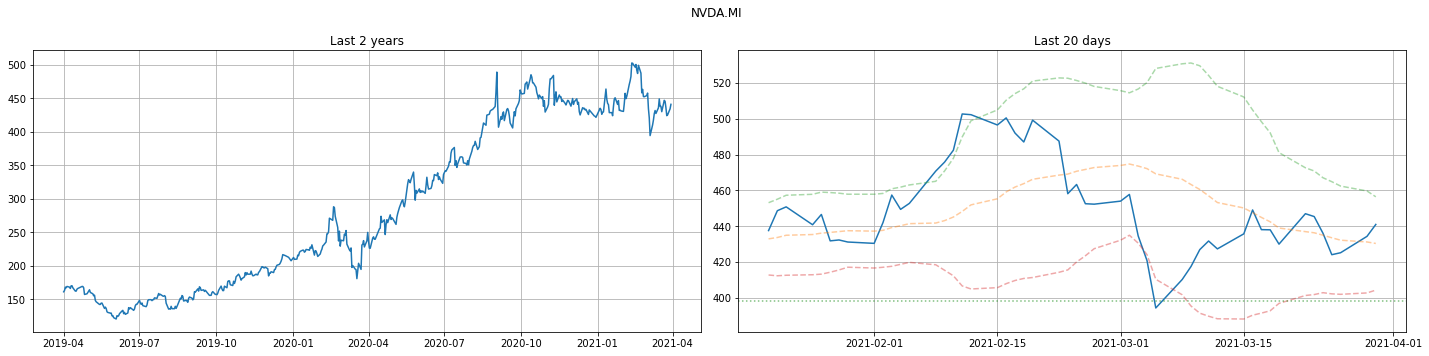


Beta:  -0.00983   Alpha:  0.00098


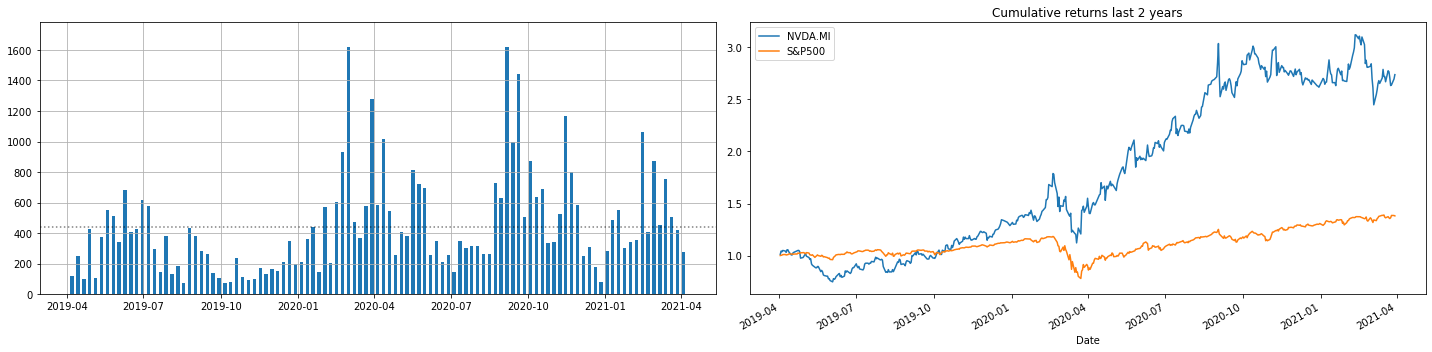

Mean Daily Return:  0.24 %
Annualized Return:  141.48 %

Mean Daily Return (last 20 days):  -0.15 %
Annualized Return (last 20 days):  -41.4 %


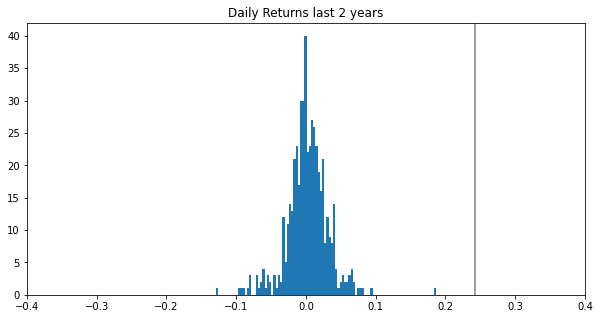


----------------------------------------------------------------



SNE
Last Price: 104.51 


Gain :   + 66 $   + 9 % 


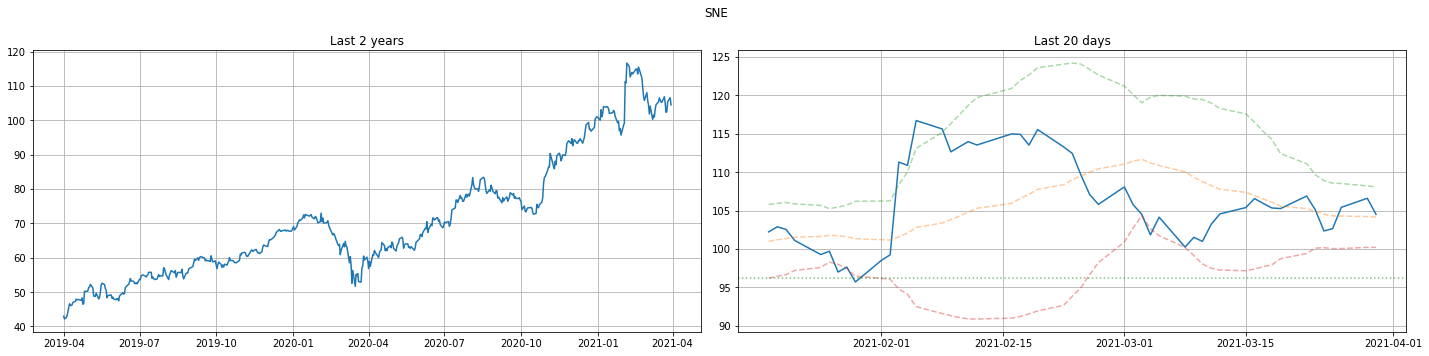


Beta:  0.59242   Alpha:  -0.0001


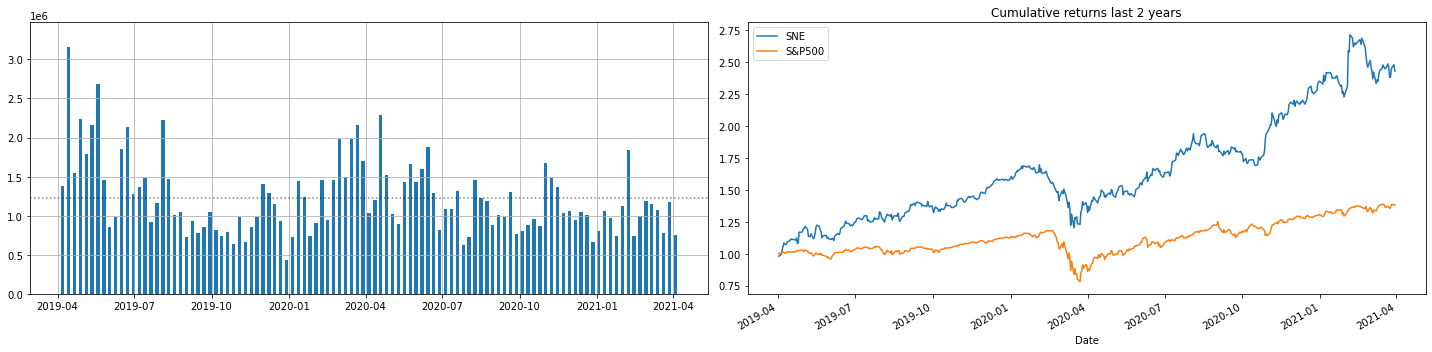

Mean Daily Return:  0.2 %
Annualized Return:  104.53 %

Mean Daily Return (last 20 days):  -0.04 %
Annualized Return (last 20 days):  -14.91 %


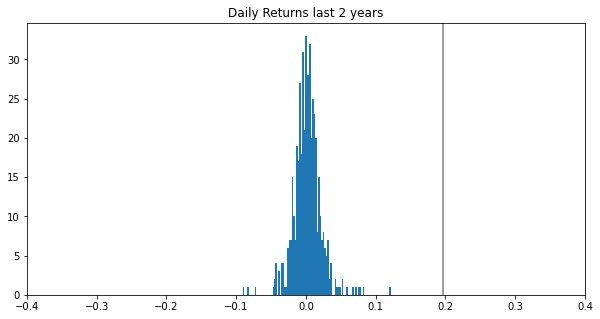


----------------------------------------------------------------



TEL
Last Price: 127.48 


Gain :   + 239 $   + 46 % 


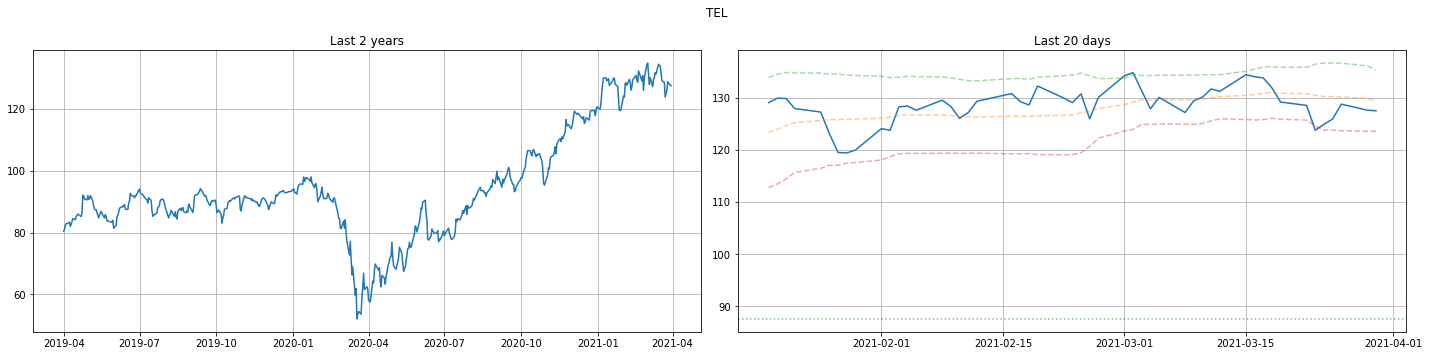


Beta:  0.53744   Alpha:  0.00026


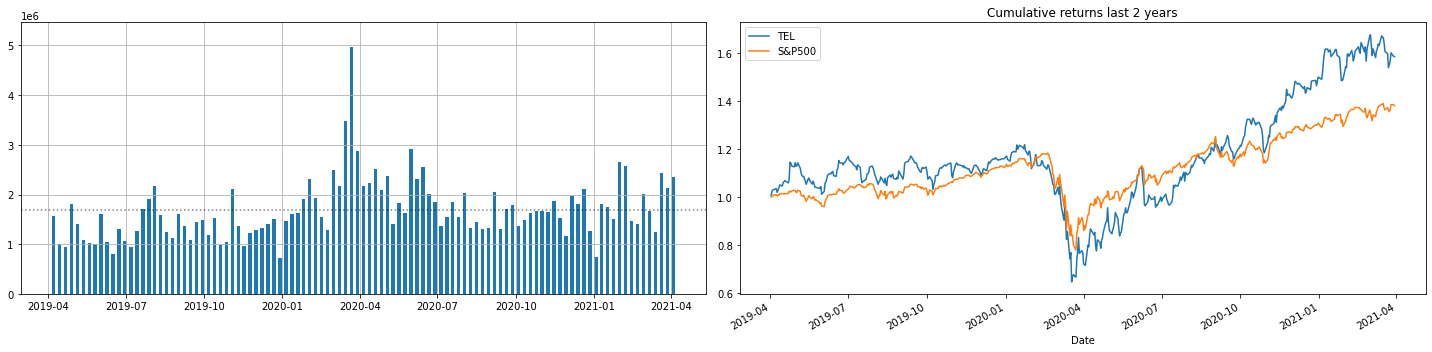

Mean Daily Return:  0.12 %
Annualized Return:  54.99 %

Mean Daily Return (last 20 days):  -0.26 %
Annualized Return (last 20 days):  -61.85 %


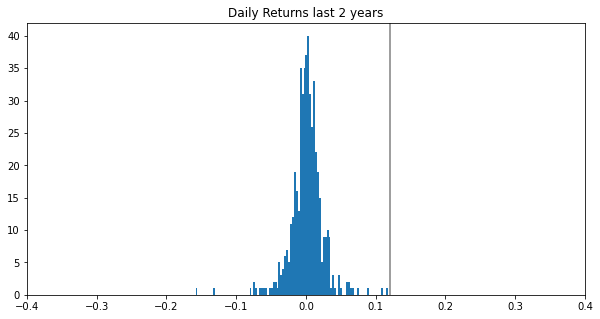


----------------------------------------------------------------



TDOC
Last Price: 174.74 


Loss :   -247 $   -19 % 


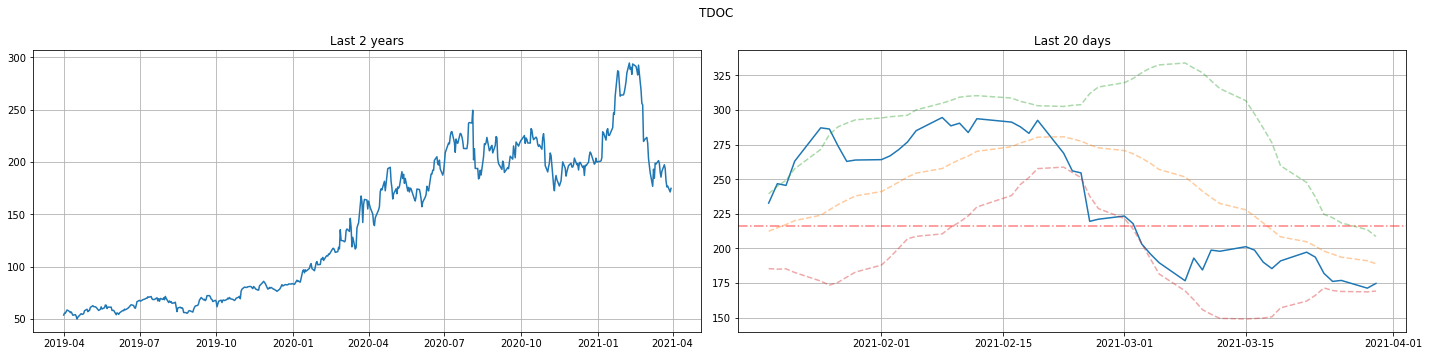


Beta:  0.06141   Alpha:  0.00072


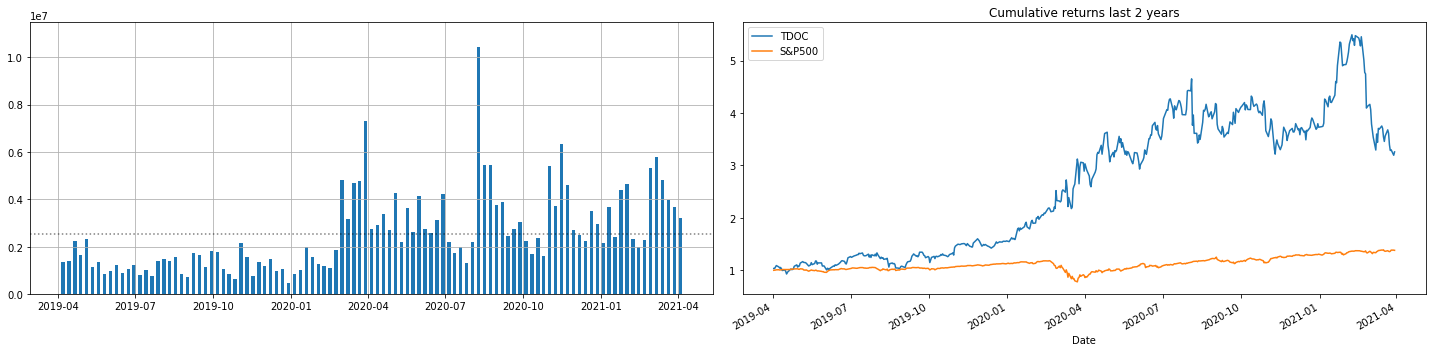

Mean Daily Return:  0.31 %
Annualized Return:  211.38 %

Mean Daily Return (last 20 days):  -1.01 %
Annualized Return (last 20 days):  -97.5 %


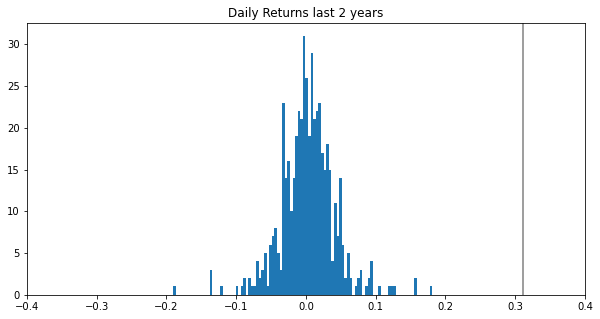


----------------------------------------------------------------



TME
Last Price: 21.34 


Loss :   -131 $   -22 % 


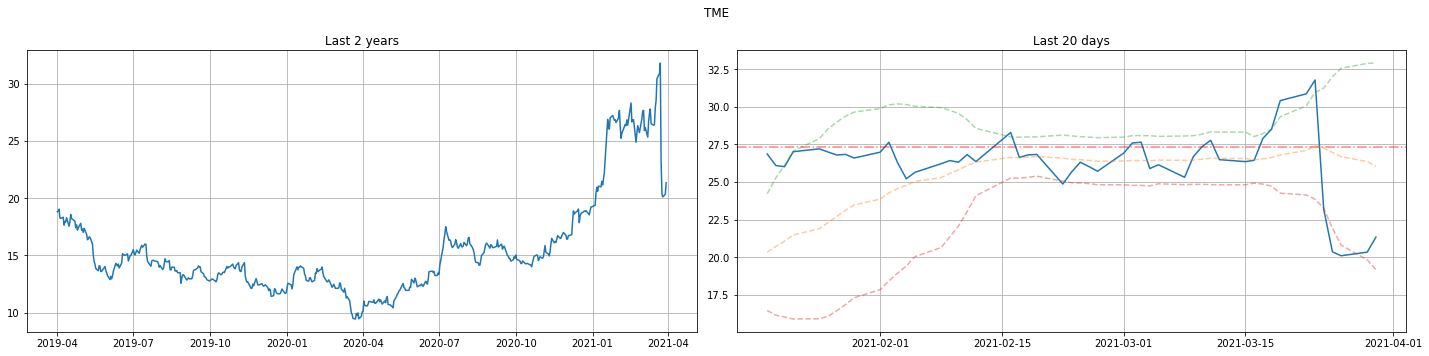


Beta:  0.14158   Alpha:  0.00069


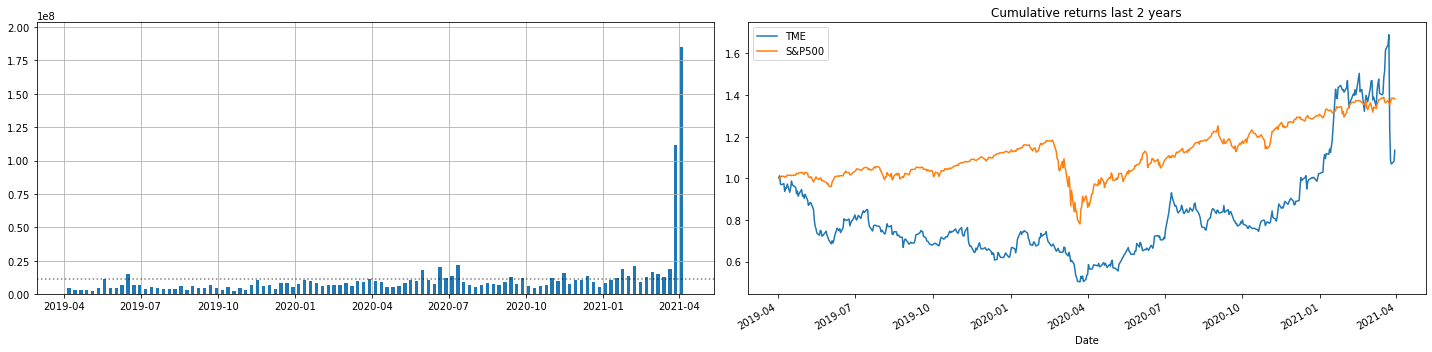

Mean Daily Return:  0.07 %
Annualized Return:  29.54 %

Mean Daily Return (last 20 days):  -0.96 %
Annualized Return (last 20 days):  -97.09 %


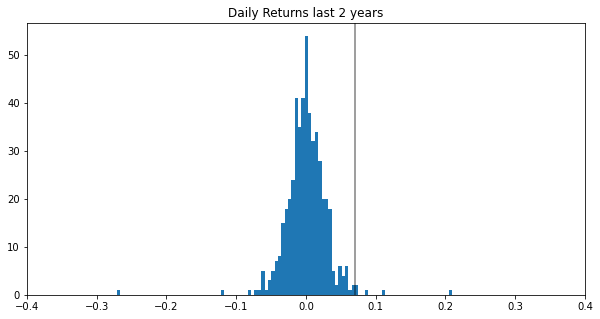


----------------------------------------------------------------



TSLA.MI
Last Price: 534.9 


Loss :   -165 $   -9 % 


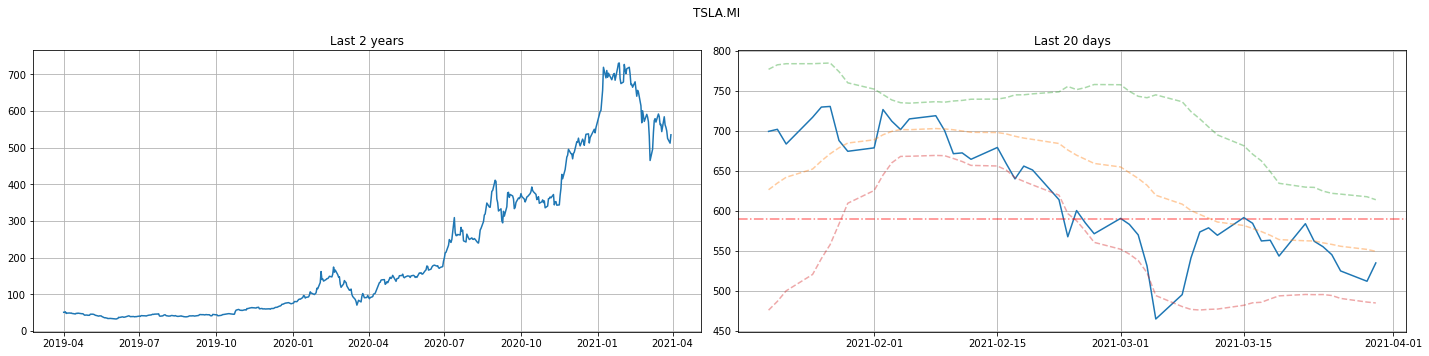


Beta:  0.01737   Alpha:  0.00082


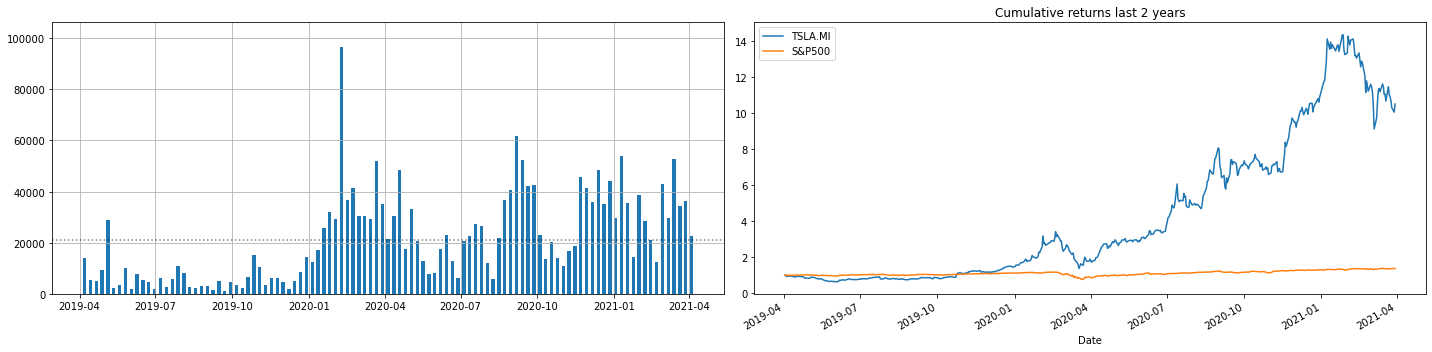

Mean Daily Return:  0.57 %
Annualized Return:  700.62 %

Mean Daily Return (last 20 days):  -0.3 %
Annualized Return (last 20 days):  -66.15 %


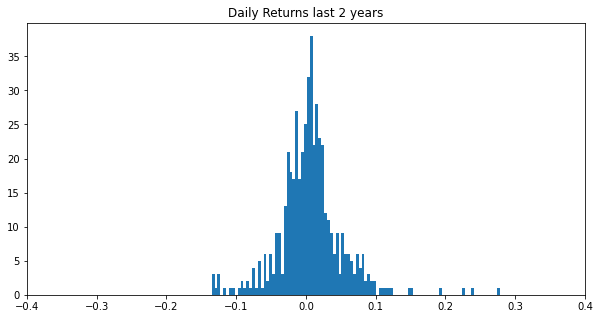


----------------------------------------------------------------



VUSA.MI
Last Price: 63.97 


Gain :   + 315 $   + 9 % 


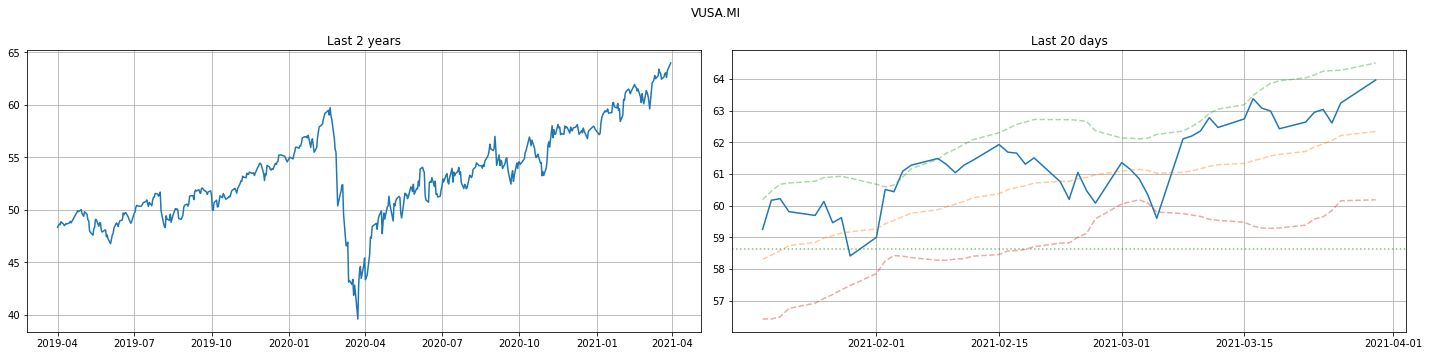


Beta:  0.21116   Alpha:  0.0008


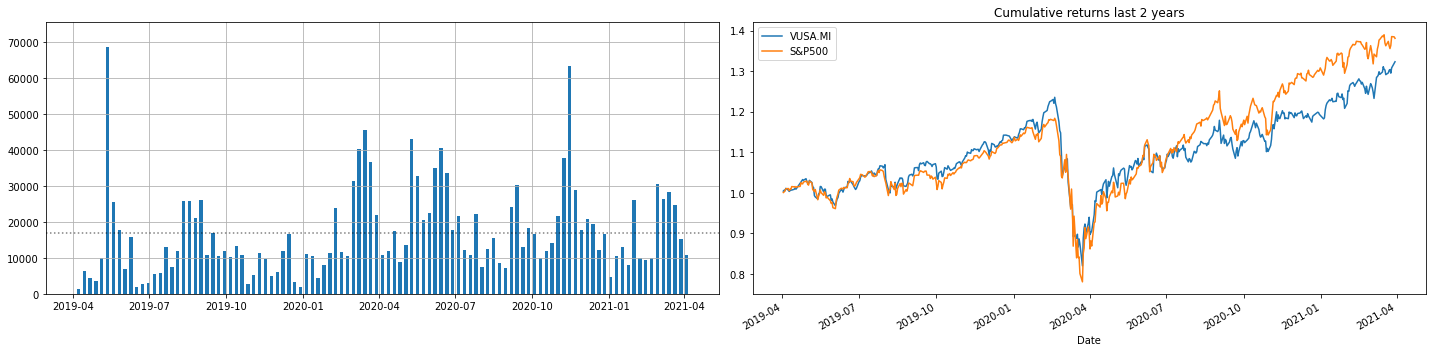

Mean Daily Return:  0.06 %
Annualized Return:  26.68 %

Mean Daily Return (last 20 days):  0.21 %
Annualized Return (last 20 days):  118.83 %


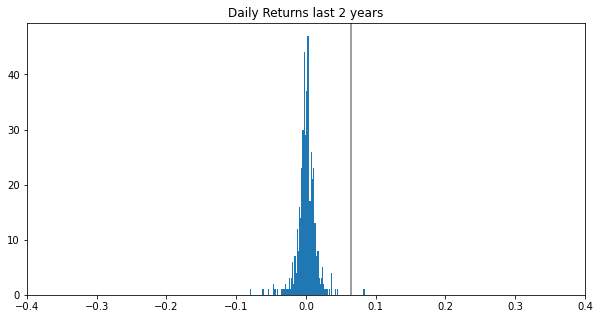


----------------------------------------------------------------



ERCB.DE
Last Price: 10.345 


Gain :   + 89 $   + 20 % 


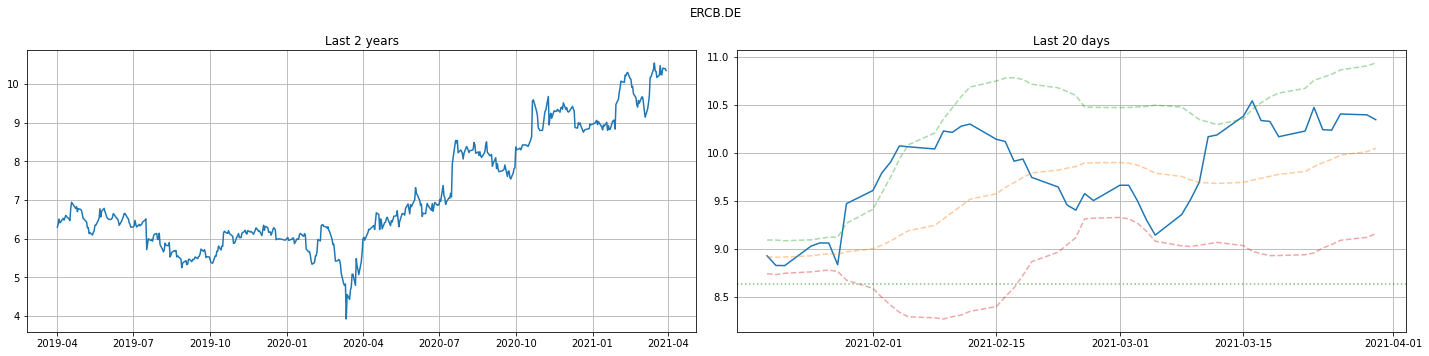


Beta:  -0.06322   Alpha:  0.00108


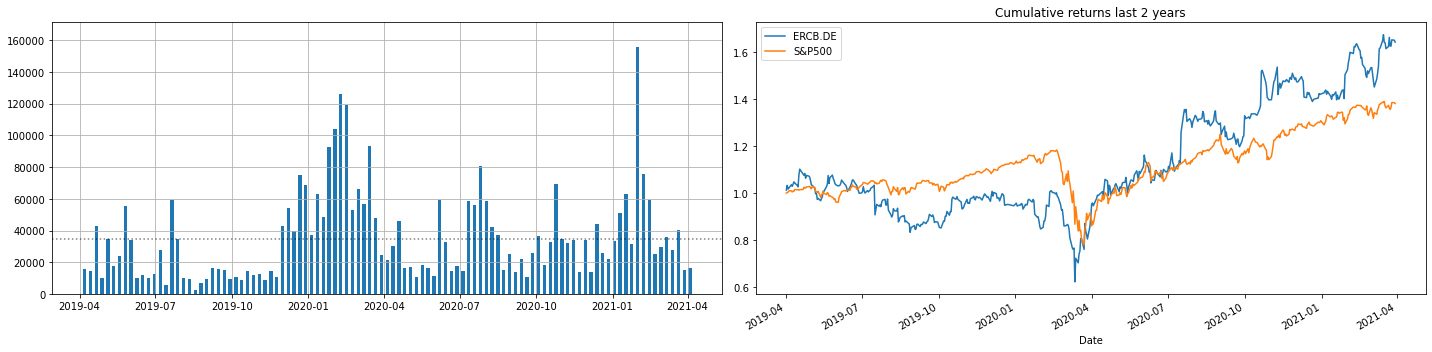

Mean Daily Return:  0.13 %
Annualized Return:  60.76 %

Mean Daily Return (last 20 days):  0.36 %
Annualized Return (last 20 days):  270.99 %


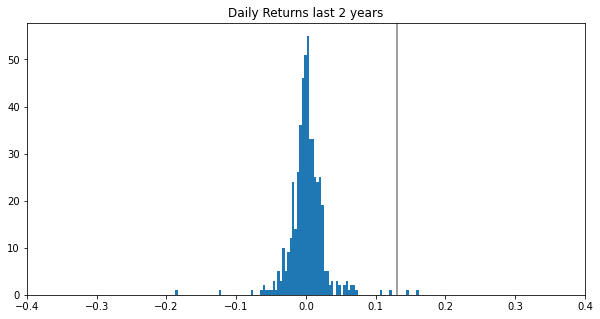


----------------------------------------------------------------



VOW3.DE
Last Price: 240.55 


Gain :   + 145 $   + 25 % 


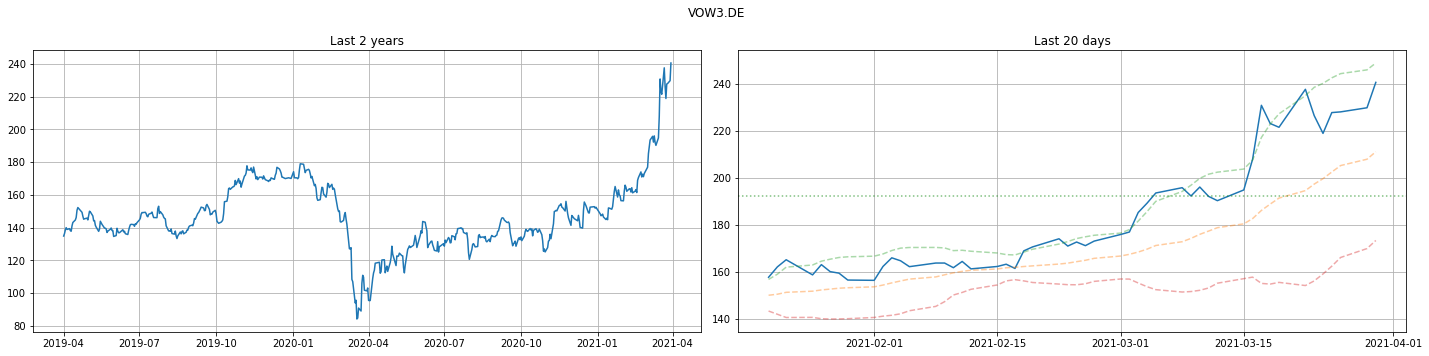


Beta:  -0.02774   Alpha:  0.001


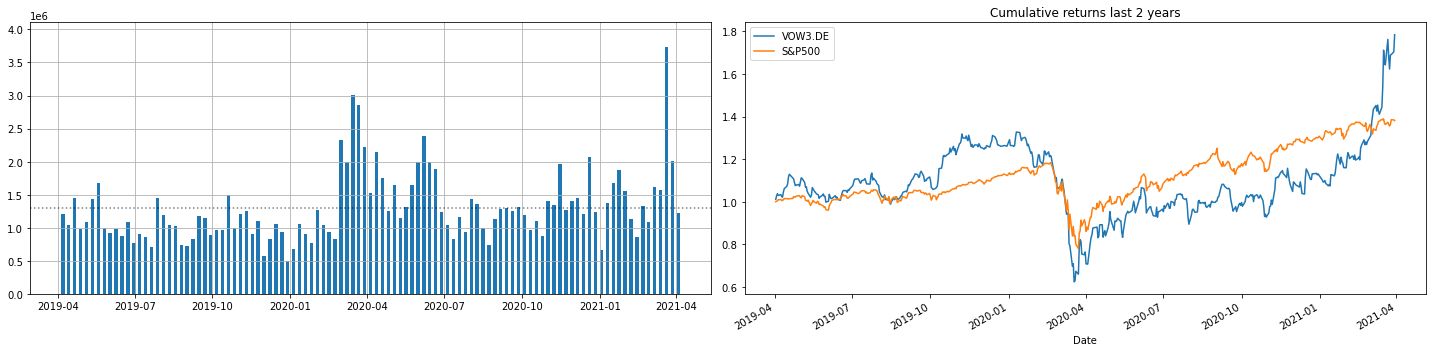

Mean Daily Return:  0.15 %
Annualized Return:  73.98 %

Mean Daily Return (last 20 days):  1.62 %
Annualized Return (last 20 days):  35526.36 %


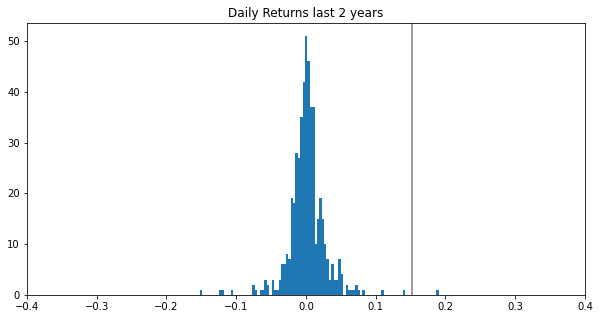

In [7]:
#ANALYSIS PER STOCK
total_gain = 0
total_invested = 0
for i in range(len(my_ticks)):
    
    #retrieve the ticker
    tick = my_ticks[i]
    #print the ticker
    print("\n----------------------------------------------------------------\n")
    print("\n\n"+'\033[1m'+'\033[94m' +tick+'\033[0m')
    
    #calculation of many values to be shown later on
    purch = portfolio.loc[i,"Purchase Price"]
    last_price =  df_list[i].tail(1)["Adj Close"]
    share = portfolio.loc[i,"Quantity"]
    gain= float(last_price-purch)
    mean_return = df_list[i]["Daily Returns"].dropna().mean()*100
    annualized_return = ((((mean_return/100)+1)**365)-1)*100
    mean_return_last20days = df_list[i]["Daily Returns"].dropna().tail(20).mean()*100
    annualized_return_last20days = ((((mean_return_last20days/100)+1)**365)-1)*100
    total_gain += gain*share
    total_invested += purch*share
    #regression of the last 400 days of the stock on the SPY
    beta, alpha, r_value, p_value, std_err = stats.linregress(df_list[i]["Daily Returns"].dropna().tail(400), spy["Daily Returns"].dropna().tail(400))
    
    #show gain or loss based on the purchased price per stock
    print('\033[1m'+'\033[94m'"Last Price:", round(float(last_price),3), '\033[0m'+"\n\n")
    if gain >= 0:
        print('\033[1m' +"Gain : "'\033[0m',end= " ") 
        print('\033[32m',"+",round(float(gain*share)),"$",end= "   ")
        print("+",round(float(gain/purch)*100),"%",'\033[0m')
    else:
        print('\033[1m' +"Loss : "'\033[0m',end= " ") 
        print('\033[31m',round(float(gain*share)),"$",end= "   ")
        print(round(float(gain/purch)*100),"%",'\033[0m')
    
    #plot of the stock price for the whole period
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,5))
    fig.suptitle(tick)
    ax1.grid()
    ax1.plot(df_list[i].index, df_list[i]["Adj Close"])
    ax1.set_title("Last 2 years")
    
    #plot of the stock price for the last 20 days 
    #togheter with the 50 days floating mean, upper and lower limit
    #shown a line with the purchase price
    ax2.grid()
    ax2.plot(df_list[i].tail(50).index, df_list[i]["Adj Close"].tail(50), alpha = 1)
    ax2.plot(df_list[i].tail(50).index, df_list[i][["20 day mean", "Upper", "Lower"]].tail(50), alpha = (.4), linestyle = "--")
    if gain >= 0:
        ax2.axhline(y=purch, color='g', linestyle='dotted', alpha=.5)
    else:
        ax2.axhline(y=purch, color='r', linestyle="-.", alpha = .5)
    
    ax2.set_title("Last 20 days")
    fig.tight_layout()
    plt.show()
    
    #show beta and alpha from the regression
    print('\033[1m' + "\nBeta: "'\033[0m', round(beta, 5), end= "   ")
    print('\033[1m' + "Alpha: "'\033[0m', round(alpha,5))
    
    #plotted the volume of sales aggregated per week (mean)
    fig, (ax21, ax22) = plt.subplots(1, 2,figsize=(20,5))
    ax21.grid()
    ax21.bar(x= df_list[i].resample(rule="w").mean().index, height=df_list[i]["Volume"].resample(rule="w").mean(), width = 4)
    ax21.axhline(y=df_list[i]["Volume"].resample(rule="w").mean().mean(), color='black', linestyle='dotted', alpha=.5)
    ax21.set_ylim(0,df_list[i]["Volume"].resample(rule="w").mean().max()*1.1)
    
    #plot cumulative return
    ax22.grid()
    ax22 = df_list[i]["Cumulative Daily Return"].plot()
    ax22 = spy["Cumulative Daily Return"].plot()
    ax22.legend([tick, "S&P500"])
    ax22.set_title("Cumulative returns last 2 years")
    fig.tight_layout()
    plt.show()
    
    #show various indexes on the returns
    print('\033[1m' +"Mean Daily Return: "'\033[0m',
          round(mean_return,2),"%",) 
    print('\033[1m' +"Annualized Return: "'\033[0m',
          round(annualized_return,2),"%") 
    print('\033[1m' +"\nMean Daily Return (last 20 days): "'\033[0m',
          round(mean_return_last20days,2),"%",) 
    print('\033[1m' +"Annualized Return (last 20 days): "'\033[0m',
      round(annualized_return_last20days,2),"%") 
    
    #plot the distribution of the daily returns over time
    plt.figure(figsize=(10,5))
    plt.hist(df_list[i]["Daily Returns"].dropna(), bins = 100)
    plt.axvline(x= mean_return,color='black', linestyle="-", alpha=.5 )
    plt.title("Daily Returns last 2 years")
    plt.xlim(-0.4,+0.4)
    plt.show()





PORTFOLIO
Gain :   + 424 $   + 4 % 


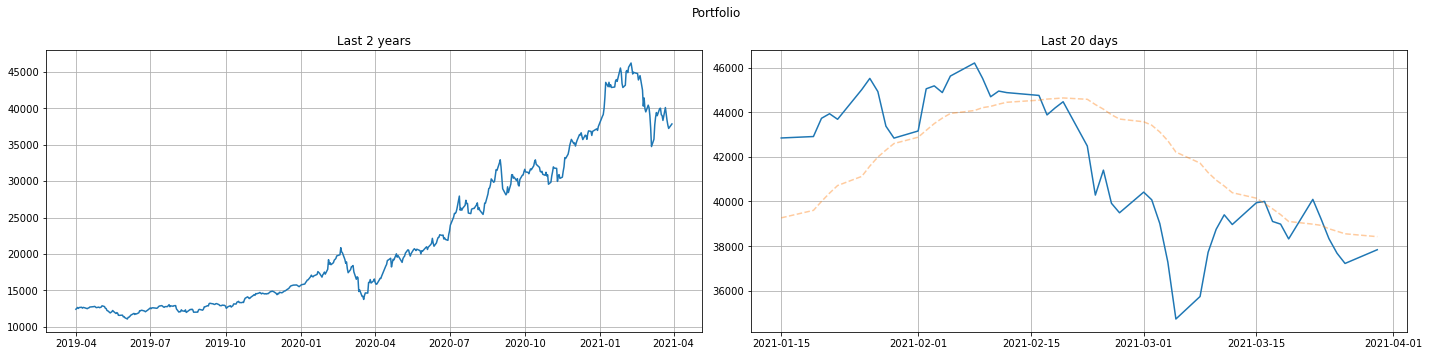


Beta:  -0.07009   Alpha:  0.00117

Sortino Ratio:  0.17524564488648012   Sharpe Ratio:  0.11921883299518939 

Mean Daily Return:  0.25 %
Annualized Return:  148.92 %

Mean Daily Return (last 20 days):  -0.29 %
Annualized Return (last 20 days):  -64.75 %


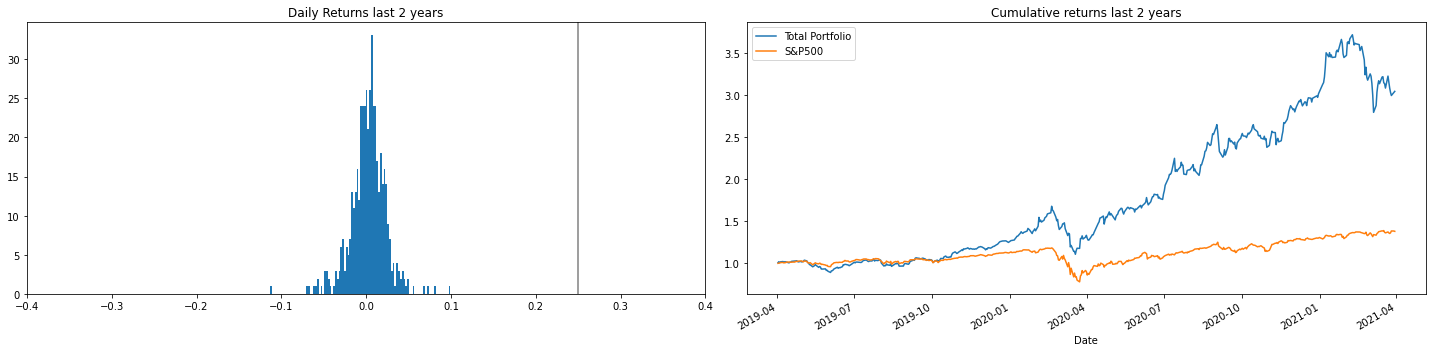

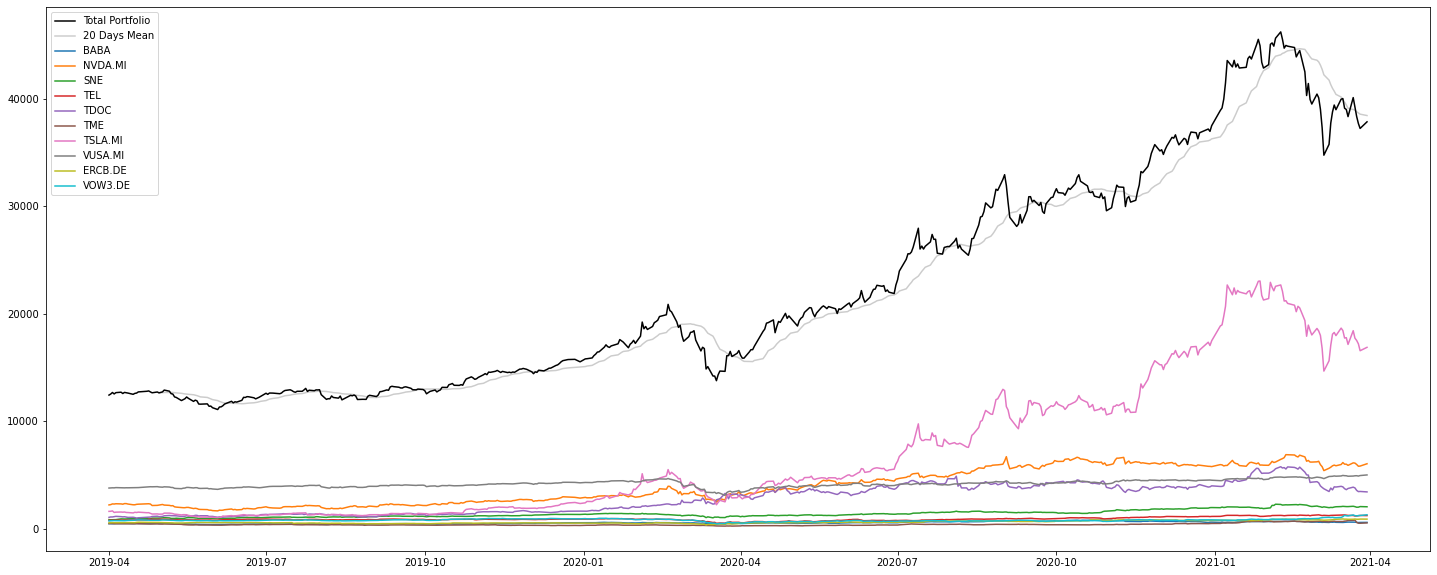

In [8]:
#ANALYSIS PORTFOLIO

#very similar process as the one for single stock
print("\n\n\n\n"+'\033[1m'+'\033[94m' +"PORTFOLIO"+'\033[0m')

if total_gain >= 0:
    print('\033[1m' +"Gain : "'\033[0m',end= " ") 
    print('\033[32m',"+",round(float(total_gain)),"$",end= "   ")
    print("+",round(float(total_gain/total_invested)*100),"%",'\033[0m')
else:
    print('\033[1m' +"Loss : "'\033[0m',end= " ") 
    print('\033[31m',round(float(total_gain)),"$",end= "   ")
    print(round(float(total_gain/total_invested)*100),"%",'\033[0m')
    
#various calcularions shown later on
mean_return = portfolio_df["Daily Returns"].dropna().mean()*100
annualized_return = ((((mean_return/100)+1)**365)-1)*100
mean_return_last20days = portfolio_df["Daily Returns"].dropna().tail(20).mean()*100
annualized_return_last20days = ((((mean_return_last20days/100)+1)**365)-1)*100
average_return = portfolio_df["Daily Returns"].mean()
volatility = np.std(portfolio_df["Daily Returns"])
downside_risk = math.sqrt(1/portfolio_df.shape[0]*sum(portfolio_df["Sortino Returns"]**2))
sharpe = average_return/volatility
sortino = average_return/downside_risk

#regression on SPY
beta, alpha, r_value, p_value, std_err = stats.linregress(portfolio_df["Daily Returns"].dropna().tail(400), spy["Daily Returns"].dropna().tail(400))

#plotted overall value over whole periods
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,5))
fig.suptitle("Portfolio")
ax1.grid()
ax1.plot(portfolio_df["Total Position"].index, portfolio_df["Total Position"])
ax1.set_title("Last 2 years")

#plotted overall value over last 20 days
ax2.grid()
ax2.plot(portfolio_df["Total Position"].tail(50).index, portfolio_df["Total Position"].tail(50), alpha = 1)
ax2.plot(portfolio_df["20 day mean"].tail(50).index, portfolio_df["20 day mean"].tail(50), alpha = (.4), linestyle = "--")

ax2.set_title("Last 20 days")
fig.tight_layout()
plt.show()

#show beta and alpha from the regression
print('\033[1m' + "\nBeta: "'\033[0m', round(beta, 5), end= "   ")
print('\033[1m' + "Alpha: "'\033[0m', round(alpha,5))

print('\033[1m' + "\nSortino Ratio: "'\033[0m',sortino, end= "   ")
print('\033[1m' + "Sharpe Ratio: "'\033[0m', sharpe, "\n")

#show various indexes on the returns
print('\033[1m' +"Mean Daily Return: "'\033[0m',
      round(mean_return,2),"%",) 
print('\033[1m' +"Annualized Return: "'\033[0m',
      round(annualized_return,2),"%") 
print('\033[1m' +"\nMean Daily Return (last 20 days): "'\033[0m',
      round(mean_return_last20days,2),"%",) 
print('\033[1m' +"Annualized Return (last 20 days): "'\033[0m',
      round(annualized_return_last20days,2),"%") 

#plot distribution of daily returns 
fig, (ax21, ax22) = plt.subplots(1, 2,figsize=(20,5))
ax21.hist(portfolio_df["Daily Returns"].dropna(), bins = 100)
ax21.axvline(x= mean_return,color='black', linestyle="-", alpha=.5 )
ax21.set_title("Daily Returns last 2 years")
ax21.set_xlim(-0.4,+0.4)

#plot cumulative daily return
ax22.grid()
ax22 = portfolio_df["Cumulative Daily Return"].plot()
ax22 = spy["Cumulative Daily Return"].plot()
ax22.legend(["Total Portfolio", "S&P500"])
ax22.set_title("Cumulative returns last 2 years")
fig.tight_layout()
plt.show()

plt.show()

#plot all the tickers together
plt.figure(figsize = (24.8,10))
plt.plot(portfolio_df["Total Position"],color="black")
plt.plot(portfolio_df["20 day mean"],color="black", alpha=0.2, linestyle="-")
plt.plot(portfolio_df[my_ticks])
plt.legend(["Total Portfolio", "20 Days Mean"]+my_ticks)
plt.show()


Average Correlation :  0.711
Average Correlation with S&P500:  0.836


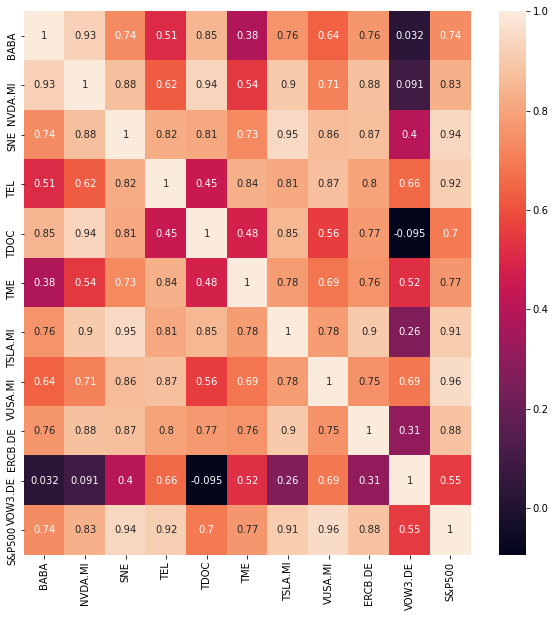

In [9]:
#CORRELATION BETWEEN STOCKS

#calculate the correlation matrix
corr_matrix = portfolio_df[my_ticks].join(spy["Adj Close"], how="left").corr()

#print some useful values
print('\033[1m' +"Average Correlation : "'\033[0m', round(corr_matrix[my_ticks].mean().mean(),3) )
print('\033[1m' +"Average Correlation with S&P500: "'\033[0m', round(corr_matrix["Adj Close"].mean(),3) )

#plot the correlation matrix
fig, ax = plt.subplots(figsize=(10,10))  
sns.heatmap(corr_matrix,annot= True)
ax.set_xticklabels(my_ticks +["S&P500"])
ax.set_yticklabels(my_ticks+["S&P500"])
plt.show()





PORTFOLIO VS INDEXES


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed




S&P

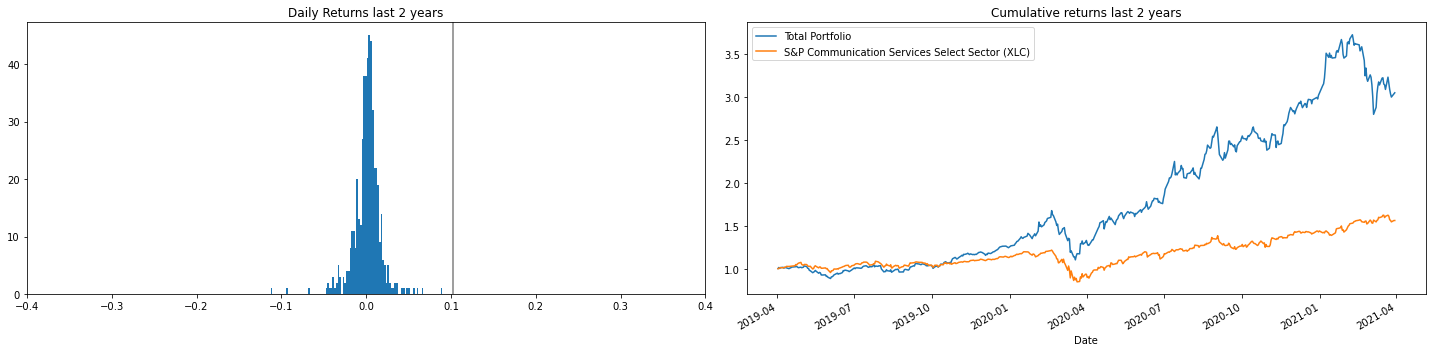





S&P Consumer Discretionary Select Sector (XLY)


Relative to portfolio, last 400 days:

Correlation:  0.53874

Beta:  -0.07562   Alpha:  0.00133


Relative to portfolio, last 100 days:

Correlation:  0.51767

Beta:  -0.0174   Alpha:  0.0014


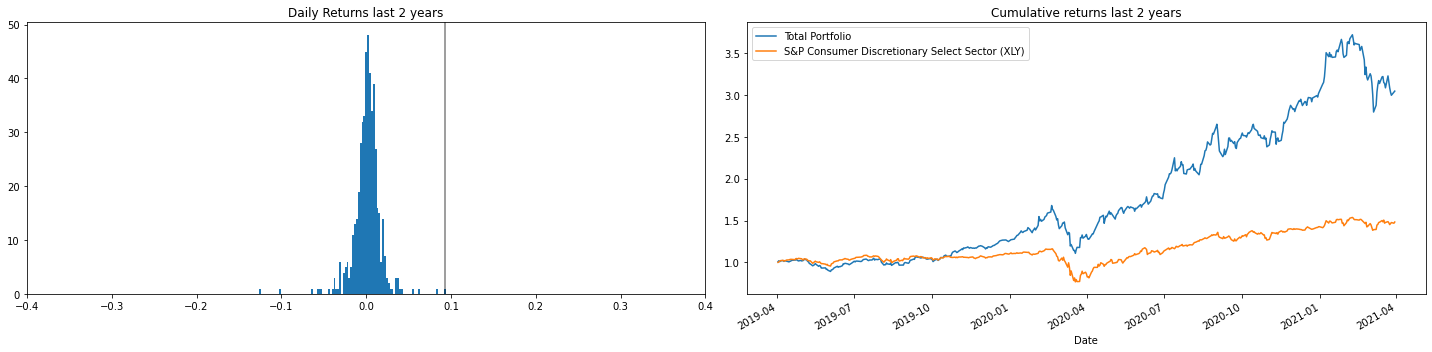





S&P Consumer Staples Select Sector (XLP)


Relative to portfolio, last 400 days:

Correlation:  0.34305

Beta:  -0.05185   Alpha:  0.00071


Relative to portfolio, last 100 days:

Correlation:  -0.01129

Beta:  -0.01138   Alpha:  0.00083


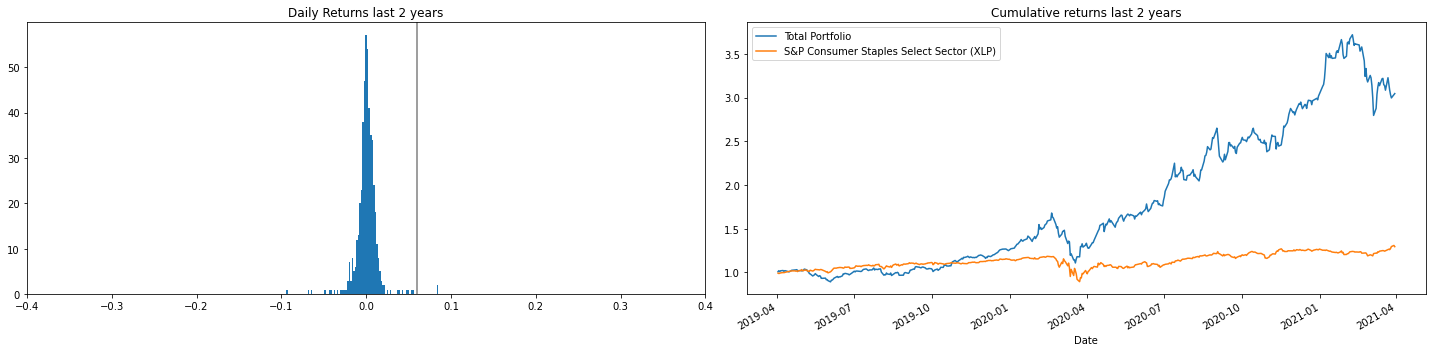





S&P Energy Select Sector (XLE)


Relative to portfolio, last 400 days:

Correlation:  0.28699

Beta:  -0.09175   Alpha:  0.0008


Relative to portfolio, last 100 days:

Correlation:  -0.08284

Beta:  0.09043   Alpha:  0.00556


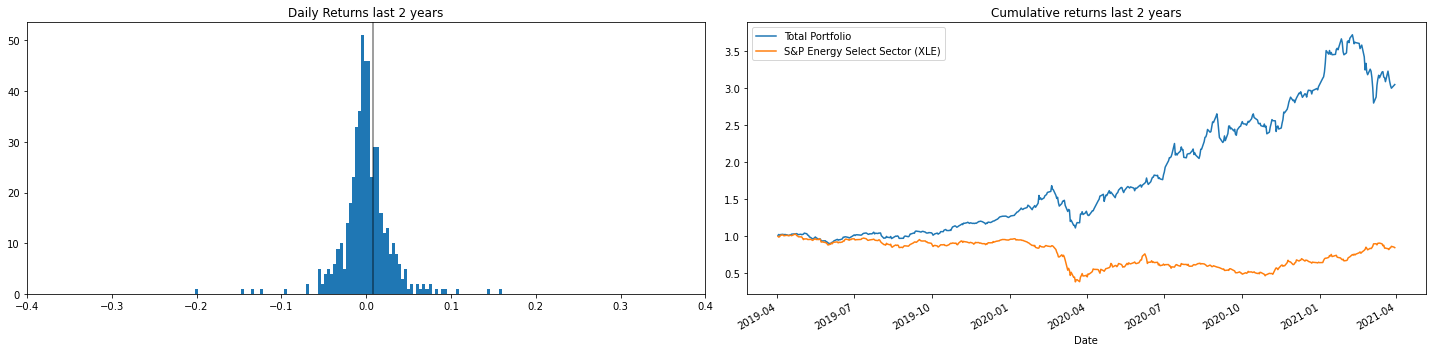





S&P Financial Select Sector (XLF)


Relative to portfolio, last 400 days:

Correlation:  0.36195

Beta:  -0.09613   Alpha:  0.00135


Relative to portfolio, last 100 days:

Correlation:  0.04922

Beta:  0.00146   Alpha:  0.00344


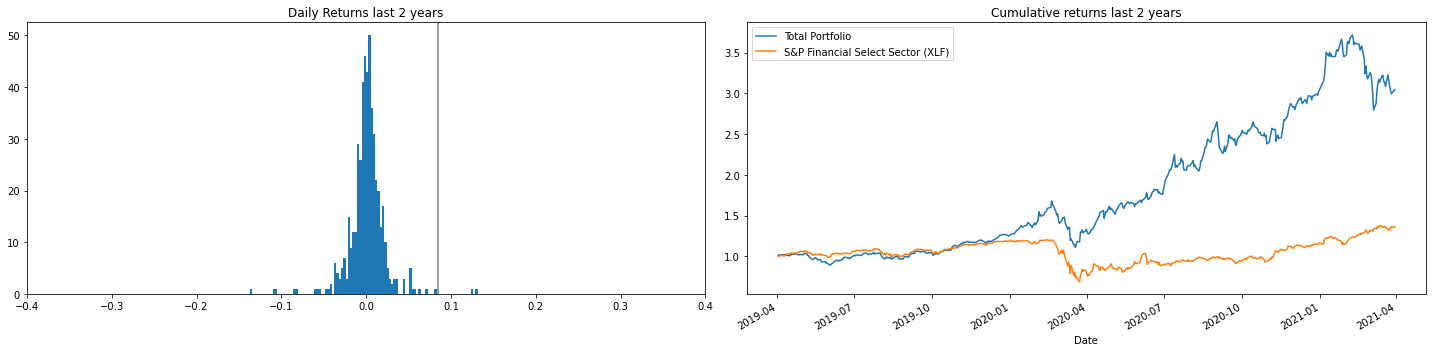





S&P Health Care Select Sector (XLV)


Relative to portfolio, last 400 days:

Correlation:  0.43828

Beta:  -0.07766   Alpha:  0.00113


Relative to portfolio, last 100 days:

Correlation:  0.10637

Beta:  -0.05   Alpha:  0.00127


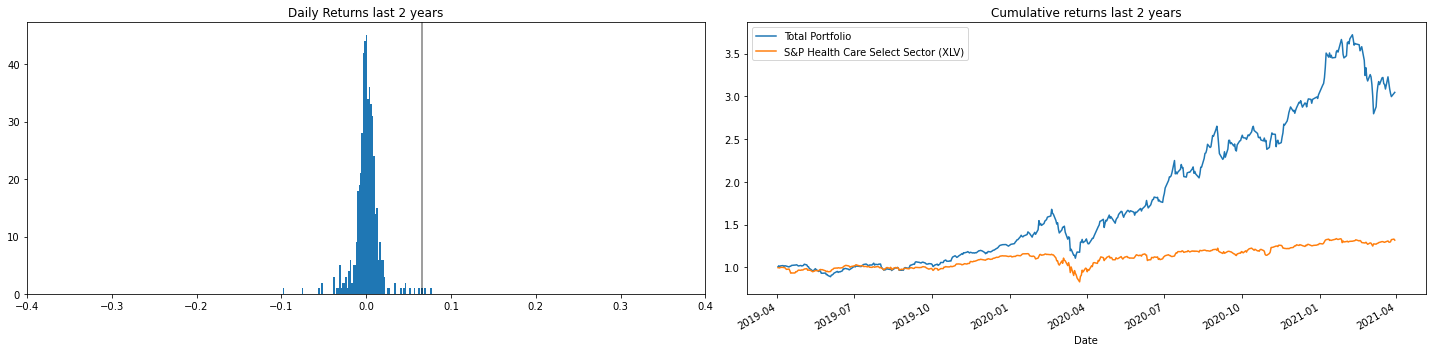





S&P Industrial Select Sector (XLI)


Relative to portfolio, last 400 days:

Correlation:  0.3837

Beta:  -0.12284   Alpha:  0.00143


Relative to portfolio, last 100 days:

Correlation:  0.04629

Beta:  -0.0495   Alpha:  0.00233


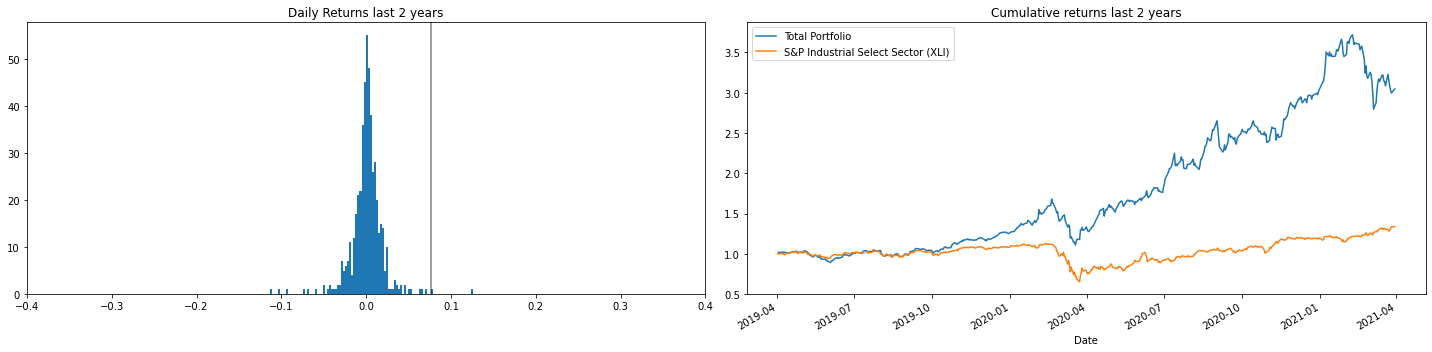





S&P Materials Select Sector (XLB)


Relative to portfolio, last 400 days:

Correlation:  0.42071

Beta:  -0.1196   Alpha:  0.00157


Relative to portfolio, last 100 days:

Correlation:  0.13293

Beta:  -0.00644   Alpha:  0.00197


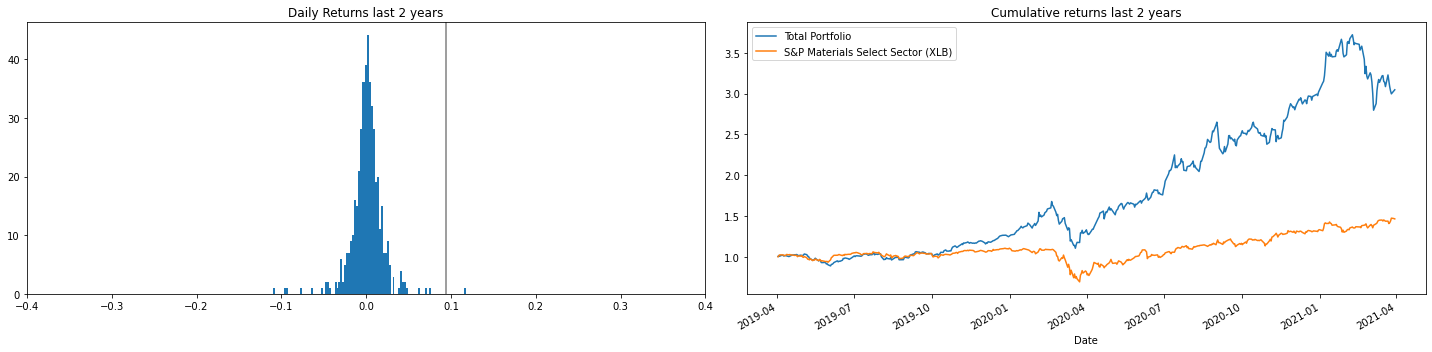





S&P Real Estate Select Sector (XLRE)


Relative to portfolio, last 400 days:

Correlation:  0.3484

Beta:  -0.09523   Alpha:  0.00072


Relative to portfolio, last 100 days:

Correlation:  0.07574

Beta:  -0.03928   Alpha:  0.00147


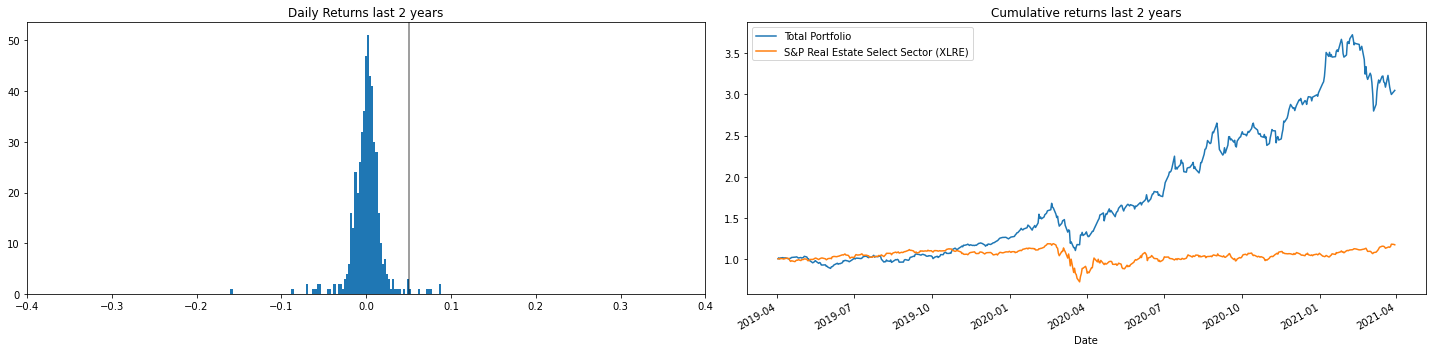





S&P Technology Select Sector (XLK)


Relative to portfolio, last 400 days:

Correlation:  0.53152

Beta:  -0.0629   Alpha:  0.00176


Relative to portfolio, last 100 days:

Correlation:  0.38595

Beta:  -0.0195   Alpha:  0.00164


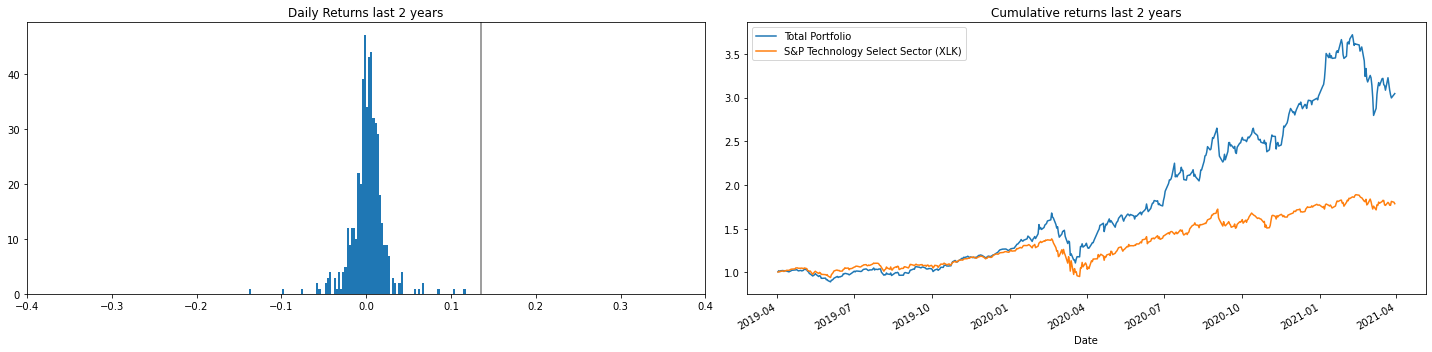





S&P Utilities Select Sector (XLU)


Relative to portfolio, last 400 days:

Correlation:  0.28417

Beta:  -0.11527   Alpha:  0.00075


Relative to portfolio, last 100 days:

Correlation:  -0.02361

Beta:  -0.00845   Alpha:  7e-05


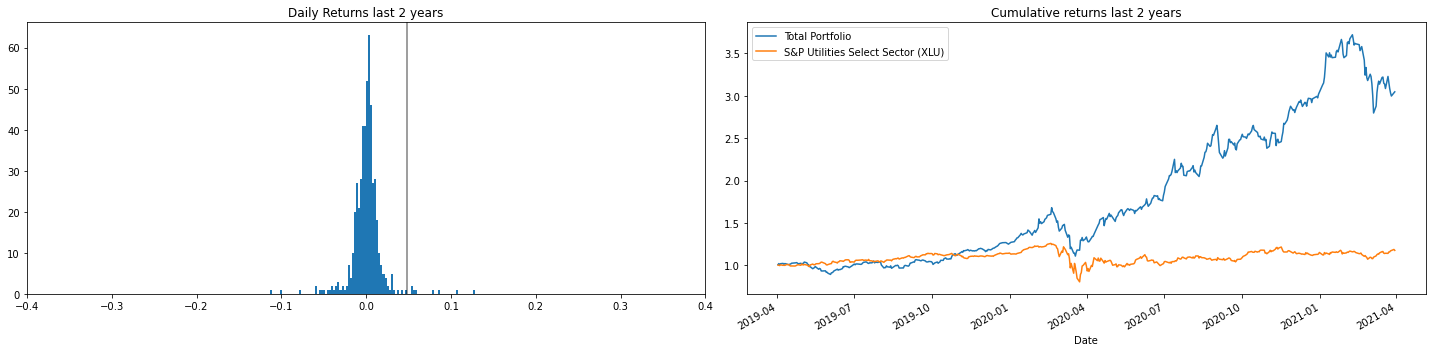





AAM S&P 500 High Dividend Value ETF (SPDV)


Relative to portfolio, last 400 days:

Correlation:  0.36165

Beta:  -0.12212   Alpha:  0.00125


Relative to portfolio, last 100 days:

Correlation:  -0.01567

Beta:  -0.01455   Alpha:  0.00299


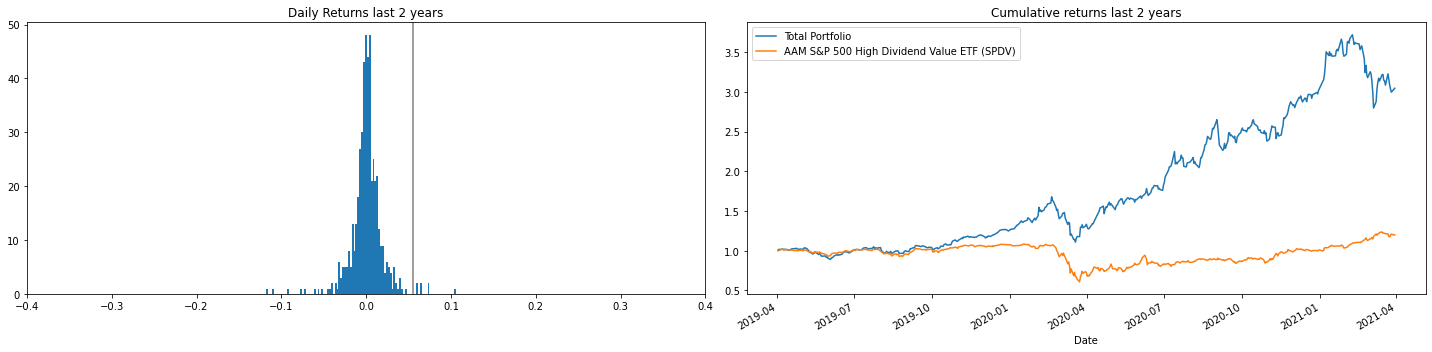





AAM S&P Developed Markets High Dividend Value ETF (DMDV)


Relative to portfolio, last 400 days:

Correlation:  0.40098

Beta:  -0.08625   Alpha:  0.00071


Relative to portfolio, last 100 days:

Correlation:  0.1235

Beta:  0.03015   Alpha:  0.00237


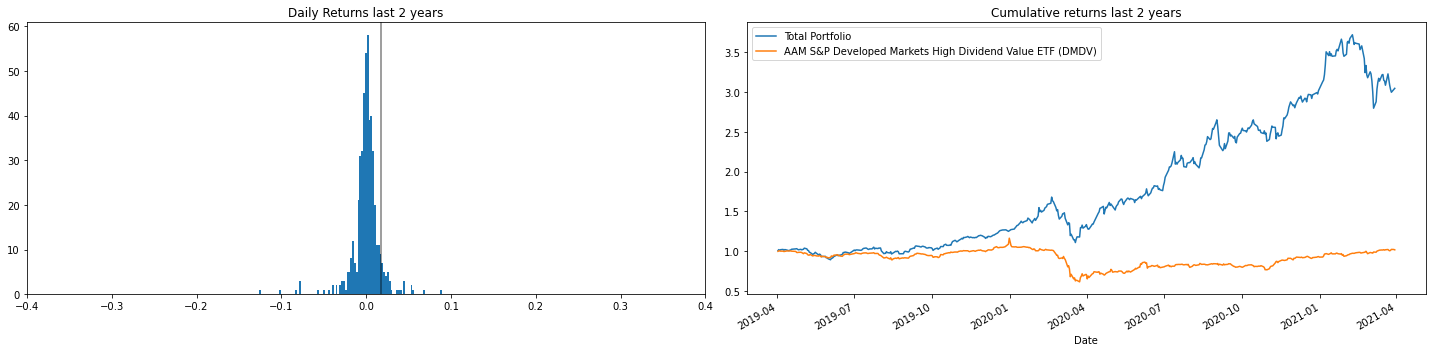





AAM S&P Emerging Markets High Dividend Value ETF (EEMD)


Relative to portfolio, last 400 days:

Correlation:  0.45501

Beta:  -0.0555   Alpha:  0.00082


Relative to portfolio, last 100 days:

Correlation:  0.23742

Beta:  0.03746   Alpha:  0.00239


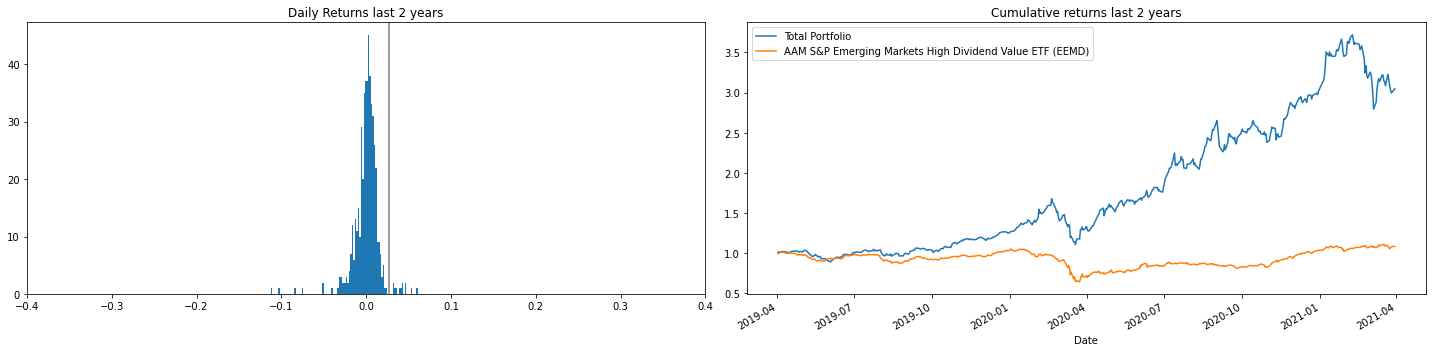

In [10]:
#COMPARISON PER INDUSTRY
print("\n\n\n\n"+'\033[1m'+'\033[94m' + "PORTFOLIO VS INDEXES"+'\033[0m'+"\n\n")
market_indexes = ("XLC", "XLY", "XLP", "XLE", "XLF", "XLV", "XLI", "XLB", "XLRE", 
           "XLK", "XLU", "SPDV", "DMDV", "EEMD")
market_index_names = ("S&P Communication Services Select Sector (XLC)",
"S&P Consumer Discretionary Select Sector (XLY)",
"S&P Consumer Staples Select Sector (XLP)",
"S&P Energy Select Sector (XLE)",
"S&P Financial Select Sector (XLF)",
"S&P Health Care Select Sector (XLV)",
"S&P Industrial Select Sector (XLI)",
"S&P Materials Select Sector (XLB)",
"S&P Real Estate Select Sector (XLRE)",
"S&P Technology Select Sector (XLK)",
"S&P Utilities Select Sector (XLU)",
"AAM S&P 500 High Dividend Value ETF (SPDV)",
"AAM S&P Developed Markets High Dividend Value ETF (DMDV)",
"AAM S&P Emerging Markets High Dividend Value ETF (EEMD)")
            
index_df_list = [yf.download(tick, period = period, interval = interval) for tick in market_indexes]

#calculations for every index
for i in range(len(market_indexes)):
    index_df_list[i]["Daily Returns"] = (index_df_list[i]["Adj Close"]/index_df_list[i]["Adj Close"].shift(1))-1
    index_df_list[i]["Cumulative Daily Return"] = (1+ index_df_list[i]["Daily Returns"]).cumprod()

corr_400_list = []
beta_400_list = []
alpha_400_list = []
corr_100_list = []
beta_100_list = []
cumulative_return_index = []


for i in range(len(market_indexes)):
    
    print("\n\n\n\n"+'\033[1m'+'\033[94m' + market_index_names[i]+'\033[0m'+"\n\n")
    
    #regression portfolio on index last 400 days
    beta_400, alpha_400, r_value_400, p_value_400, std_err_400 = stats.linregress(portfolio_df["Daily Returns"].dropna().tail(400), index_df_list[i]["Daily Returns"].dropna().tail(400))
    
    #correlation between portfolio and index last 400 days
    corr_400 = portfolio_df["Daily Returns"].dropna().tail(400).corr(index_df_list[i]["Daily Returns"].dropna().tail(400))
    
    #show beta and alpha from the regression last 400 days
    print("Relative to portfolio, last 400 days:")
    print('\033[1m' + "\nCorrelation: "'\033[0m', round(corr_400, 5))
    print('\033[1m' + "\nBeta: "'\033[0m', round(beta_400, 5), end= "   ")
    print('\033[1m' + "Alpha: "'\033[0m', round(alpha_400,5))
    
    #regression portfolio on index last 100 days
    beta_100, alpha_100, r_value_100, p_value_100, std_err_100 = stats.linregress(portfolio_df["Daily Returns"].dropna().tail(100), index_df_list[i]["Daily Returns"].dropna().tail(100))
    
    #correlation between portfolio and index last 100 days
    corr_100 = portfolio_df["Daily Returns"].dropna().tail(100).corr(index_df_list[i]["Daily Returns"].dropna().tail(100))
    
    #show beta and alpha from the regression last 400 days
    print("\n\nRelative to portfolio, last 100 days:")
    print('\033[1m' + "\nCorrelation: "'\033[0m', round(corr_100, 5))
    print('\033[1m' + "\nBeta: "'\033[0m', round(beta_100, 5), end= "   ")
    print('\033[1m' + "Alpha: "'\033[0m', round(alpha_100,5))
    
    #appending the values
    corr_400_list.append(corr_400)
    beta_400_list.append(beta_400)
    alpha_400_list.append(alpha_400)
    corr_100_list.append(corr_100)
    beta_100_list.append(beta_100)
    cumulative_return_index.append(float(index_df_list[i]["Cumulative Daily Return"].tail(1)))
    
    
    #plot distribution of daily returns 
    mean_return = index_df_list[i]["Daily Returns"].dropna().mean()*100
    fig, (ax21, ax22) = plt.subplots(1, 2,figsize=(20,5))
    ax21.hist(index_df_list[i]["Daily Returns"].dropna(), bins = 100)
    ax21.axvline(x= mean_return,color='black', linestyle="-", alpha=.5 )
    ax21.set_title("Daily Returns last 2 years")
    ax21.set_xlim(-0.4,+0.4)
    
    #plot cumulative daily return
    ax22.grid()
    ax22 = portfolio_df["Cumulative Daily Return"].plot()
    ax22 = index_df_list[i]["Cumulative Daily Return"].plot()
    ax22.legend(["Total Portfolio", market_index_names[i]])
    ax22.set_title("Cumulative returns last 2 years")
    fig.tight_layout()
    plt.show()
    
    plt.show()

#a table for fast comparison across indexes
index_table = pd.DataFrame(list(zip(market_index_names,cumulative_return_index, corr_400_list, beta_400_list, 
                           alpha_400_list, corr_100_list, beta_100_list)),
                  columns =["Index", "cumulative return", "corr_400", "beta_400", "alpha_400",
                           "corr_100", "beta_100"])

#color formatting to aid the comparison
display(index_table.style.\
       hide_index().\
       background_gradient(cmap='RdYlGn',subset= ["cumulative return","corr_400", "beta_400", "alpha_400",
                           "corr_100", "beta_100"]))

Sharpe Ratio optimization, all time query


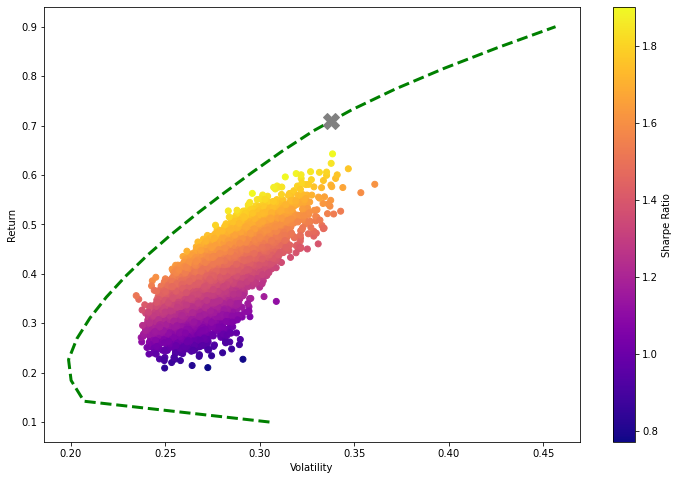

Actual Values 

Return : 0.4247756221920651
Volatility : 0.27193833489776437
Sharpe Ratio : 1.5620292091284598


Optimization results 

Return : 0.7097261360557214
Volatility : 0.33774163919744854
Sharpe Ratio : 2.1013877286265124

 BABA 
Actual:  0.04      Optimal:  0.0

 NVDA.MI 
Actual:  0.18      Optimal:  0.03

 SNE 
Actual:  0.07      Optimal:  0.53

 TEL 
Actual:  0.06      Optimal:  0.0

 TDOC 
Actual:  0.08      Optimal:  0.14

 TME 
Actual:  0.04      Optimal:  0.0

 TSLA.MI 
Actual:  0.13      Optimal:  0.3

 VUSA.MI 
Actual:  0.3      Optimal:  0.0

 ERCB.DE 
Actual:  0.04      Optimal:  0.0

 VOW3.DE 
Actual:  0.06      Optimal:  0.0


In [11]:
#SHARPE RATIO OPTIMIZATION
print("Sharpe Ratio optimization, all time query")

#put together all the adj. close for every stock
stocks = portfolio_df[my_ticks]
#calculate the logarithmic returns
log_ret= np.log(stocks/stocks.shift(1))

#we are gonna take 10000 random weights to plot the sharpe ratio distribution
num_ports = 10000

#empty arrays for weights, return, volatility, sharpe ratio
all_weights = np.zeros((num_ports, len(stocks.columns)))
ret_arr = np.zeros(num_ports)
vol_arr = np.zeros(num_ports)
sharpe_arr = np.zeros(num_ports)

#for loop to create random weights and calculate return, volatility and sharpe ratio
for ind in range(num_ports):
    weights = np.array(np.random.random(len(stocks.columns)))
    weights = weights/np.sum(weights)
    all_weights[ind,:] = weights
    ret_arr[ind]=  np.sum((log_ret.mean()*weights)*252)
    vol_arr[ind] = np.sqrt(np.dot(weights.T,np.dot(log_ret.cov()*252,weights)))
    sharpe_arr[ind] = ret_arr[ind]/vol_arr[ind]

#Takes in weights, returns array or return,volatility, sharpe ratio
#useful to translate the final result of the optimization in its coefficient
def get_ret_vol_sr(weights):
    
    weights = np.array(weights)
    ret = np.sum(log_ret.mean() * weights) * 252
    vol = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov() * 252, weights)))
    sr = ret/vol
    return np.array([ret,vol,sr])

#we are going to minimize the negative sharpe ratio (== maximize the sharpe ratio)
def neg_sharpe(weights):
    return  get_ret_vol_sr(weights)[2] * -1

#constraint formula: returns zero if sum of weights is 1.0
def check_sum(weights):
    return np.sum(weights) - 1

#constraint dictionary
cons = ({'type':'eq','fun': check_sum})

# 0-1 bounds for each weight
bounds = ((0, 1),)*len(stocks.columns)
#initial guess with all weights equal
init_guess = list(np.repeat(1/len(stocks.columns), len(stocks.columns)))

#optimization with SLSQP
opt_results = minimize(neg_sharpe,init_guess,method='SLSQP',bounds=bounds,constraints=cons)

# Create a linspace number of points where we'll calculate the frontier
frontier_y = np.linspace(0.1,0.9,20) 

#function to minimize to find the frontier
def minimize_volatility(weights):
    return  get_ret_vol_sr(weights)[1] 
frontier_volatility = []

#run the optimization for every value in the linspace
for possible_return in frontier_y:
    #constraints: sum of weights == 0 and don't modify the return
    cons = ({'type':'eq','fun': check_sum},
            {'type':'eq','fun': lambda w: get_ret_vol_sr(w)[0] - possible_return})
    
    #optimization to minimize volatility
    result = minimize(minimize_volatility,init_guess,method='SLSQP',bounds=bounds,constraints=cons)
    
    frontier_volatility.append(result['fun'])
    
opt_results.x
opt_values = get_ret_vol_sr(opt_results.x)
actual_values = get_ret_vol_sr(portfolio["% of allocation"])
    
#plot of the results
plt.figure(figsize=(12,8))
plt.scatter(vol_arr,ret_arr,c=sharpe_arr,cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')

# Add frontier line
plt.plot(frontier_volatility,frontier_y,'g--',linewidth=3)
plt.plot(opt_values[1],opt_values[0],'X', color = "grey", markersize=16) 
plt.show()

opt_results.x
opt_values = get_ret_vol_sr(opt_results.x)
actual_values = get_ret_vol_sr(portfolio["% of allocation"])

#print of the results
print('\033[1m' +"Actual Values \n"'\033[0m')
print('\033[1m' +"Return :"'\033[0m',actual_values[0])
print('\033[1m' +"Volatility :"'\033[0m',actual_values[1])
print('\033[1m' +"Sharpe Ratio :"'\033[0m',actual_values[2])

print('\033[1m' +"\n\nOptimization results \n"'\033[0m')
print('\033[1m' +"Return :"'\033[0m',opt_values[0])
print('\033[1m' +"Volatility :"'\033[0m',opt_values[1])
print('\033[1m' +"Sharpe Ratio :"'\033[0m',opt_values[2])

for i in range(len(my_ticks)):
    print("\n",'\033[1m'+my_ticks[i]+'\033[0m',"\nActual: ",round(portfolio.loc[i,"% of allocation"],2),"     Optimal: ",round(opt_results.x[i],2))


In [12]:
#SHARPE RATIO OPTIMIZATION (custom) [1]
#Variables for custom optimization
print("""If "optimal", optimization on Sharpe Ratio.
If "volatility", optimization with volatility max (select max volatility).""")
print("Select how much % of the portfolio for each stock can be allocated")
print("Select how many days in the past consider for the analysis.")


radiobuttons1 = widgets.RadioButtons(
    value='optimal', 
    options=['optimal', 'volatility'], 
    description='Parameters'
)

int_slider1 = widgets.IntSlider(
    value=30, 
    min=0, max=50, step=1, 
    description='Max volatility %'
)




int_slider2 = widgets.IntSlider(
    value=200, 
    min=0, max=500, step=1, 
    description='Days'
)

int_slider3 = widgets.IntSlider(
    value=60, 
    min=0, max=100, step=1, 
    description='Max % per stock'
)

widgets.VBox(
    [
        radiobuttons1,
        int_slider1, 
        int_slider3,
        int_slider2

    ]
)

If "optimal", optimization on Sharpe Ratio.
If "volatility", optimization with volatility max (select max volatility).
Select how much % of the portfolio for each stock can be allocated
Select how many days in the past consider for the analysis.


Sharpe Ratio optimization, last 200 days


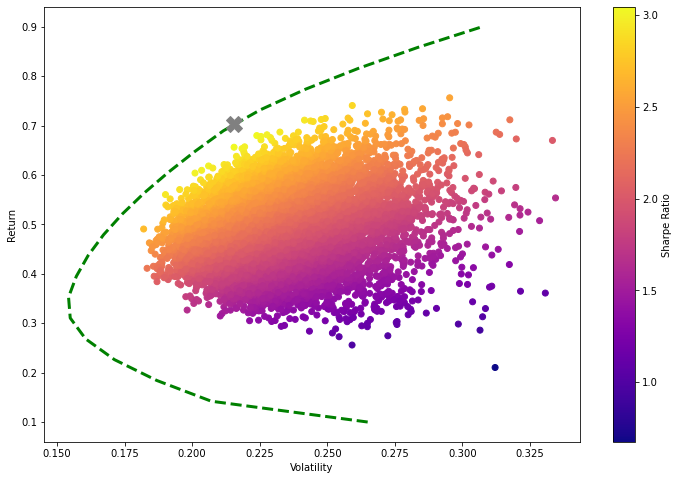

Actual Values 

Return : 0.46748481229944633
Volatility : 0.22522448372220538
Sharpe Ratio : 2.075639400181944


Optimization results 

Return : 0.7025587305282177
Volatility : 0.21538213223585947
Sharpe Ratio : 3.26191742664551

 BABA 
Actual:  0.04      Optimal:  0.0

 NVDA.MI 
Actual:  0.18      Optimal:  0.0

 SNE 
Actual:  0.07      Optimal:  0.28

 TEL 
Actual:  0.06      Optimal:  0.18

 TDOC 
Actual:  0.08      Optimal:  0.0

 TME 
Actual:  0.04      Optimal:  0.07

 TSLA.MI 
Actual:  0.13      Optimal:  0.16

 VUSA.MI 
Actual:  0.3      Optimal:  0.0

 ERCB.DE 
Actual:  0.04      Optimal:  0.1

 VOW3.DE 
Actual:  0.06      Optimal:  0.22


In [13]:
#SHARPE RATIO OPTIMIZATION (custom)
opt_or_vol = radiobuttons1.value
days = int_slider2.value
max_volatility = int_slider1.value/100
max_per_stock = int_slider3.value/100



print(f"Sharpe Ratio optimization, last {days} days")
stocks = portfolio_df[my_ticks].tail(days)
log_ret= np.log(stocks/stocks.shift(1))

num_ports = 10000
all_weights = np.zeros((num_ports, len(stocks.columns)))
ret_arr = np.zeros(num_ports)
vol_arr = np.zeros(num_ports)
sharpe_arr = np.zeros(num_ports)

for ind in range(num_ports):
    weights = np.array(np.random.random(len(stocks.columns)))
    weights = weights/np.sum(weights)
    all_weights[ind,:] = weights
    ret_arr[ind]=  np.sum((log_ret.mean()*weights)*252)
    vol_arr[ind] = np.sqrt(np.dot(weights.T,np.dot(log_ret.cov()*252,weights)))
    sharpe_arr[ind] = ret_arr[ind]/vol_arr[ind]


def get_ret_vol_sr(weights):
    """
    Takes in weights, returns array or return,volatility, sharpe ratio
    """
    weights = np.array(weights)
    ret = np.sum(log_ret.mean() * weights) * 252
    vol = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov() * 252, weights)))
    sr = ret/vol
    return np.array([ret,vol,sr])

def neg_sharpe(weights):
    return  get_ret_vol_sr(weights)[2] * -1

# Contraints
def check_sum(weights):

    return np.sum(weights) - 1

cons = ({'type':'eq','fun': check_sum})
# 0-1 bounds for each weight
bounds = ((0, max_per_stock),)*len(stocks.columns)
init_guess = list(np.repeat(1/len(stocks.columns), len(stocks.columns)))
opt_results = minimize(neg_sharpe,init_guess,method='SLSQP',bounds=bounds,constraints=cons)

# Create a linspace number of points to calculate x on
frontier_y = np.linspace(0.1,0.9,20) 
def minimize_volatility(weights):
    return  get_ret_vol_sr(weights)[1] 
frontier_volatility = []

for possible_return in frontier_y:
    # function for return
    cons = ({'type':'eq','fun': check_sum},
            {'type':'eq','fun': lambda w: get_ret_vol_sr(w)[0] - possible_return})
    
    result = minimize(minimize_volatility,init_guess,method='SLSQP',bounds=bounds,constraints=cons)
    
    frontier_volatility.append(result['fun'])

opt_results.x
opt_values = get_ret_vol_sr(opt_results.x)
actual_values = get_ret_vol_sr(portfolio["% of allocation"])
    
plt.figure(figsize=(12,8))
plt.scatter(vol_arr,ret_arr,c=sharpe_arr,cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')

# Add frontier line
plt.plot(frontier_volatility,frontier_y,'g--',linewidth=3)
plt.plot(opt_values[1],opt_values[0],'X', color = "grey", markersize=16) 
plt.show()


if opt_or_vol == "optimal":
    print('\033[1m' +"Actual Values \n"'\033[0m')
    print('\033[1m' +"Return :"'\033[0m',actual_values[0])
    print('\033[1m' +"Volatility :"'\033[0m',actual_values[1])
    print('\033[1m' +"Sharpe Ratio :"'\033[0m',actual_values[2])
    
    print('\033[1m' +"\n\nOptimization results \n"'\033[0m')
    print('\033[1m' +"Return :"'\033[0m',opt_values[0])
    print('\033[1m' +"Volatility :"'\033[0m',opt_values[1])
    print('\033[1m' +"Sharpe Ratio :"'\033[0m',opt_values[2])
    
    for i in range(len(my_ticks)):
        print("\n",'\033[1m'+my_ticks[i]+'\033[0m',"\nActual: ",round(portfolio.loc[i,"% of allocation"],2),"     Optimal: ",round(opt_results.x[i],2))
elif opt_or_vol == "volatility":
        
    cons = ({'type':'eq','fun': check_sum},
            {'type':'eq','fun': lambda w: get_ret_vol_sr(w)[1] - max_volatility})
    vol_result = minimize(neg_sharpe,init_guess,method='SLSQP',bounds=bounds,constraints=cons)
    vol_values = get_ret_vol_sr(vol_result.x)
    if round(actual_values[1], 2) > max_volatility:
        print('\033[91m'+"Impossible to reach desired volatility with given stocks\n\n"+'\033[0m')
    print('\033[1m' +"Actual Values \n"'\033[0m')
    print('\033[1m' +"Return :"'\033[0m',actual_values[0])
    print('\033[1m' +"Volatility :"'\033[0m',actual_values[1])
    print('\033[1m' +"Sharpe Ratio :"'\033[0m',actual_values[2])
    
    print('\033[1m' +"\n\nOptimization results \n"'\033[0m')
    print('\033[1m' +"Return :"'\033[0m',vol_values[0])
    print('\033[1m' +"Volatility :"'\033[0m',vol_values[1])
    print('\033[1m' +"Sharpe Ratio :"'\033[0m',vol_values[2])
    
    for i in range(len(my_ticks)):
        print("\n",'\033[1m'+my_ticks[i]+'\033[0m',"\nActual: ",round(portfolio.loc[i,"% of allocation"],2),"     Optimal: ",round(vol_result.x[i],2))
    
else:
    print("error")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

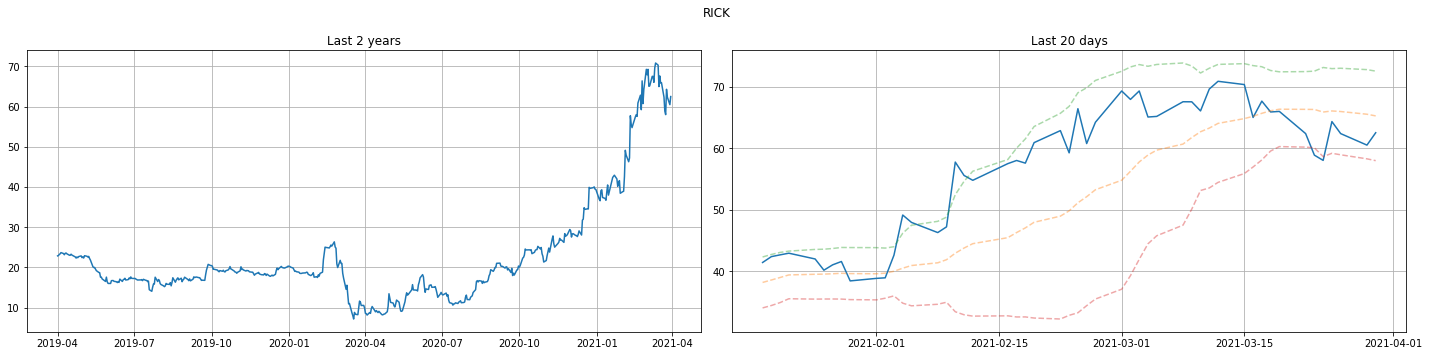

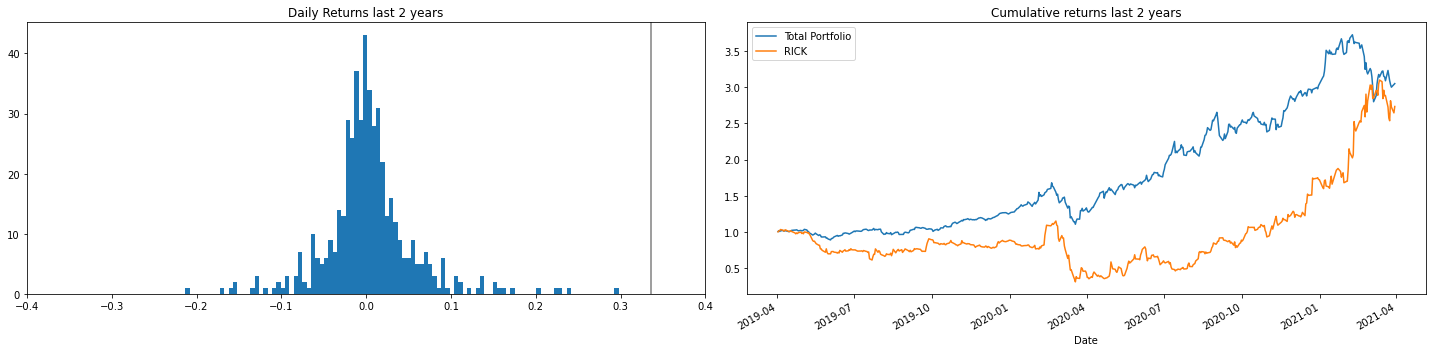

Relative to portfolio, last 400 days:

Correlation:  0.22629

Beta:  -0.04036   Alpha:  0.0033


Relative to portfolio, last 100 days:

Correlation:  -0.01459

Beta:  -0.04134   Alpha:  0.00278

----------------------------------------------------------------



RBLX
Last Price: 65.17 


Mean Daily Return:  -0.3 %
Annualized Return:  -66.94 %

Mean Daily Return (last 20 days):  -0.3 %
Annualized Return (last 20 days):  -66.94 %


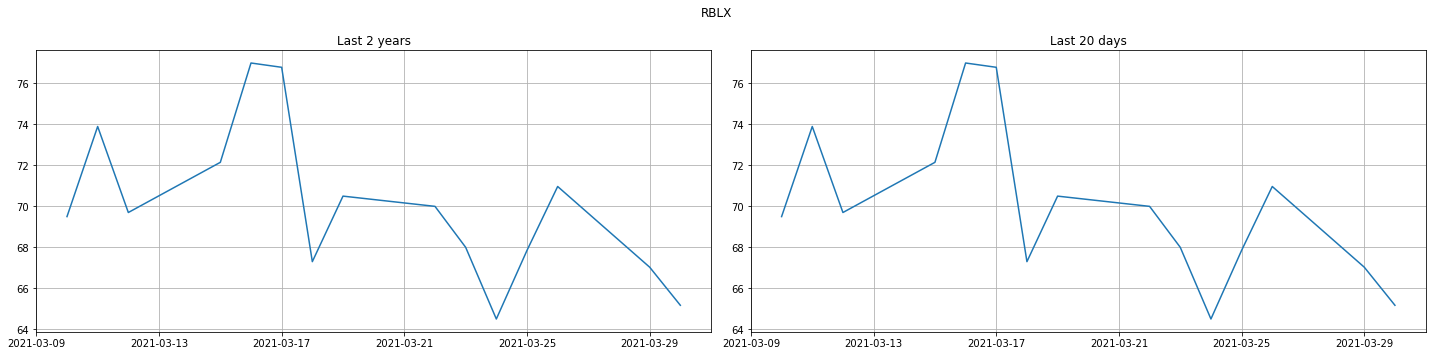

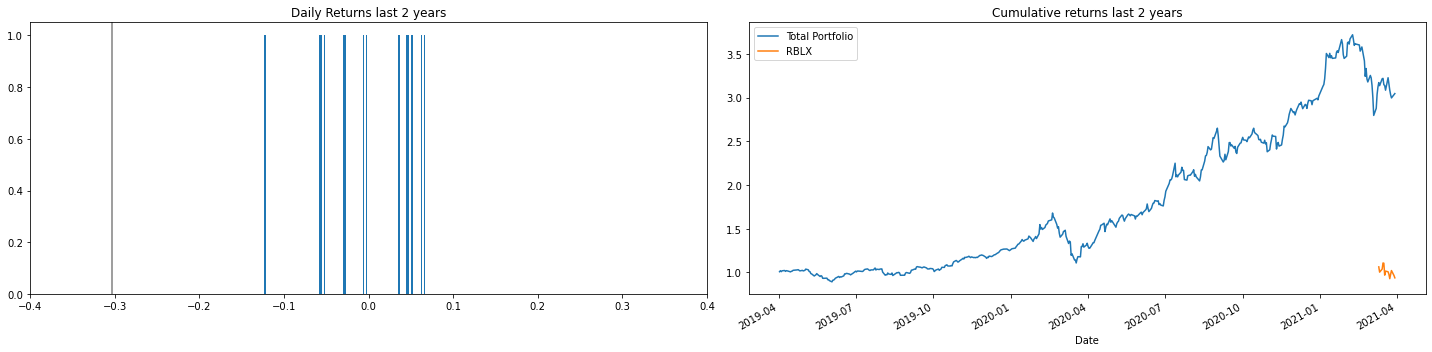


no data for last 400 days
Relative to portfolio, last 400 days:

Correlation:  0

Beta:  0   Alpha:  0

no data for last 100, not 50 days


Relative to portfolio, last 100 days:

Correlation:  0

Beta:  0   Alpha:  0

----------------------------------------------------------------



RMS.PA
Last Price: 947.4 


Mean Daily Return:  0.1 %
Annualized Return:  46.65 %

Mean Daily Return (last 20 days):  0.13 %
Annualized Return (last 20 days):  58.28 %


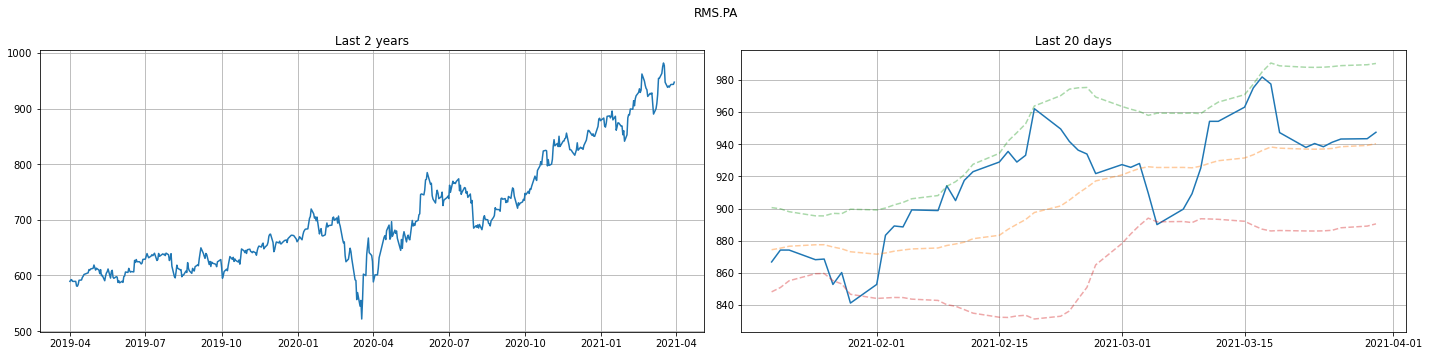

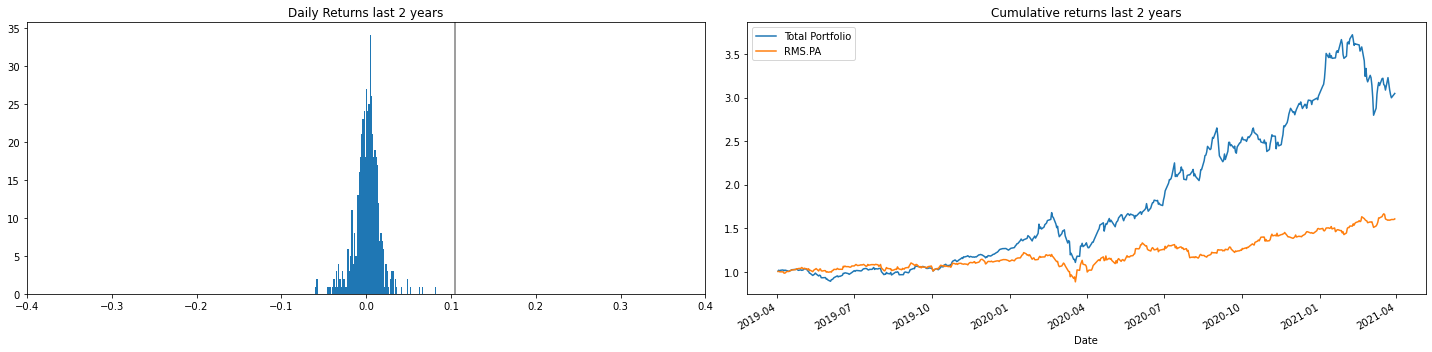

Relative to portfolio, last 400 days:

Correlation:  0.49585

Beta:  0.04222   Alpha:  0.00305


Relative to portfolio, last 100 days:

Correlation:  0.35399

Beta:  0.23086   Alpha:  0.00199

----------------------------------------------------------------



DAI.DE
Last Price: 75.94 


Mean Daily Return:  0.13 %
Annualized Return:  62.43 %

Mean Daily Return (last 20 days):  0.55 %
Annualized Return (last 20 days):  634.45 %


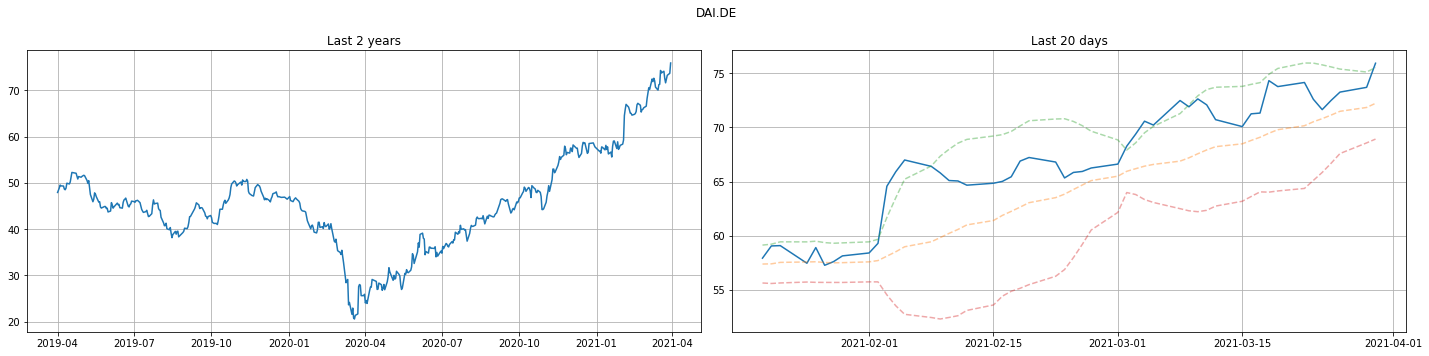

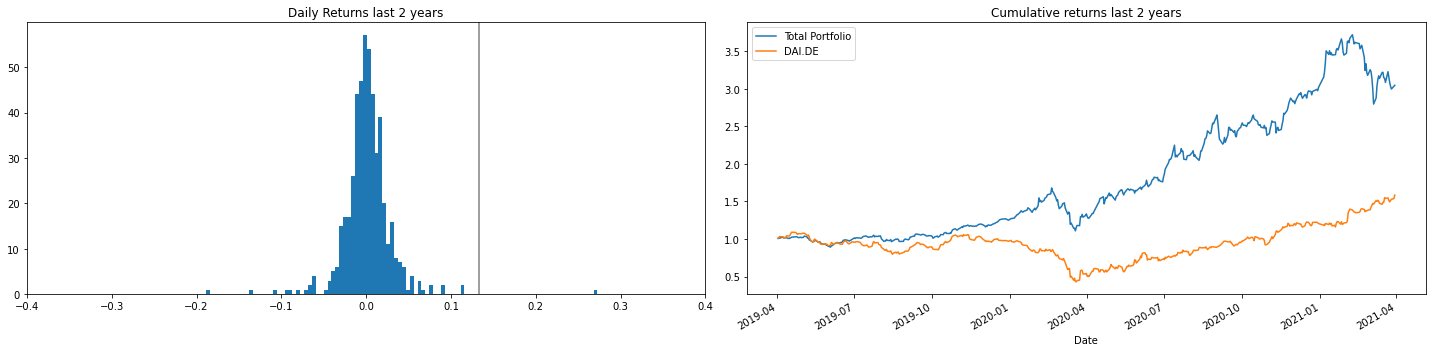

Relative to portfolio, last 400 days:

Correlation:  0.43823

Beta:  0.03075   Alpha:  0.00303


Relative to portfolio, last 100 days:

Correlation:  0.09297

Beta:  -0.09311   Alpha:  0.00275

----------------------------------------------------------------



CCL
Last Price: 26.65 


Mean Daily Return:  0.04 %
Annualized Return:  14.53 %

Mean Daily Return (last 20 days):  -0.1 %
Annualized Return (last 20 days):  -30.06 %


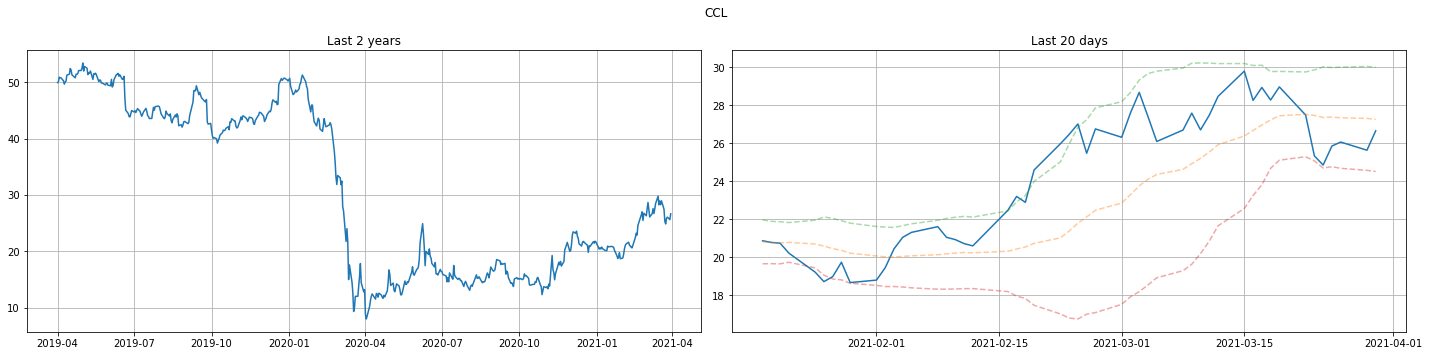

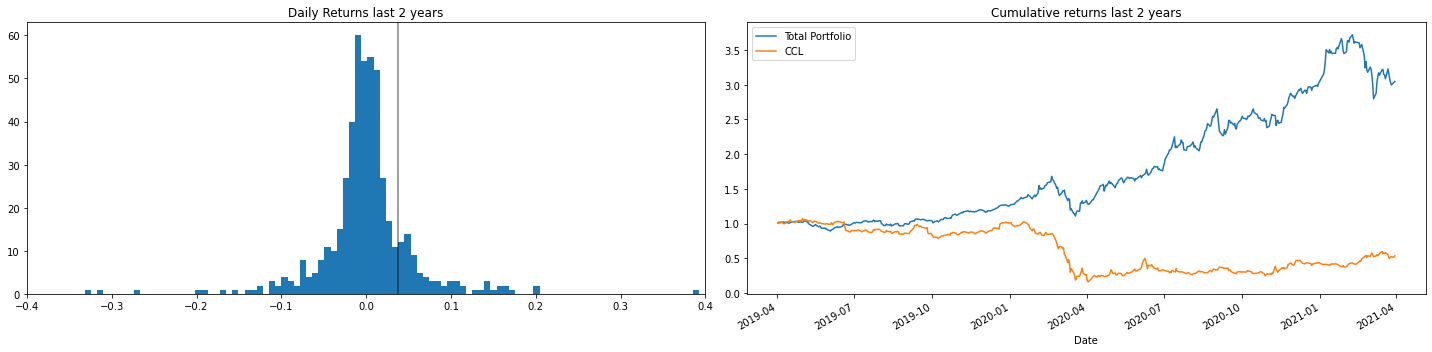

Relative to portfolio, last 400 days:

Correlation:  0.26157

Beta:  -0.05433   Alpha:  0.00315


Relative to portfolio, last 100 days:

Correlation:  0.11474

Beta:  0.00335   Alpha:  0.00228

----------------------------------------------------------------



ROKU
Last Price: 311.96 


Mean Daily Return:  0.41 %
Annualized Return:  339.49 %

Mean Daily Return (last 20 days):  -1.02 %
Annualized Return (last 20 days):  -97.59 %


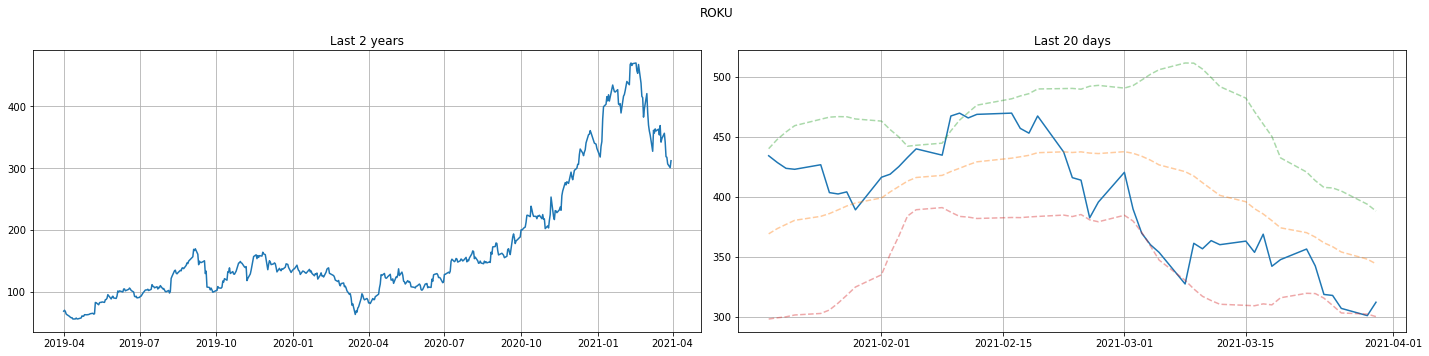

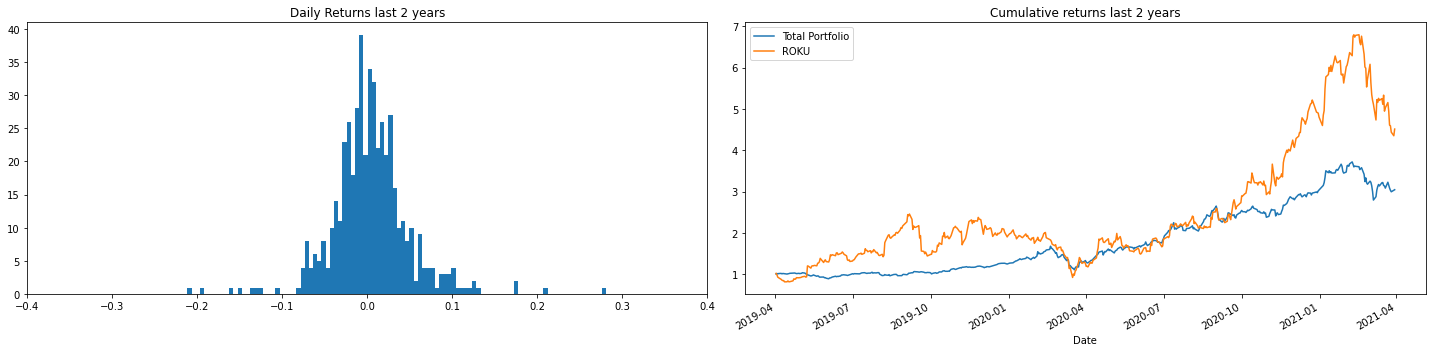

Relative to portfolio, last 400 days:

Correlation:  0.35881

Beta:  0.02593   Alpha:  0.00302


Relative to portfolio, last 100 days:

Correlation:  0.36753

Beta:  0.08083   Alpha:  0.00189

----------------------------------------------------------------



000800.SZ
Last Price: 10.95 


Mean Daily Return:  0.09 %
Annualized Return:  39.8 %

Mean Daily Return (last 20 days):  -0.32 %
Annualized Return (last 20 days):  -69.5 %


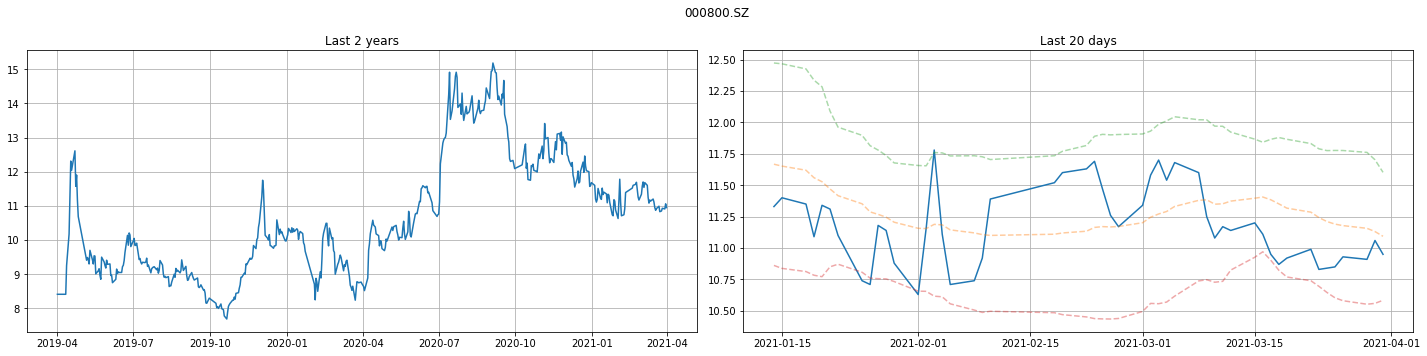

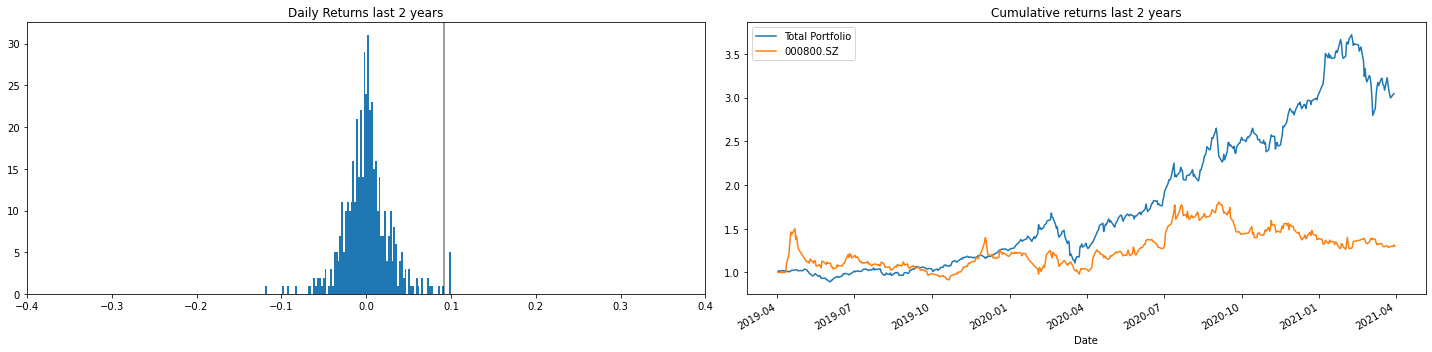

Relative to portfolio, last 400 days:

Correlation:  0.09314

Beta:  -0.03977   Alpha:  0.00313


Relative to portfolio, last 100 days:

Correlation:  0.14091

Beta:  -0.06104   Alpha:  0.00225

----------------------------------------------------------------



NFLX.MI
Last Price: 434.55 


Mean Daily Return:  0.09 %
Annualized Return:  38.77 %

Mean Daily Return (last 20 days):  -0.2 %
Annualized Return (last 20 days):  -51.55 %


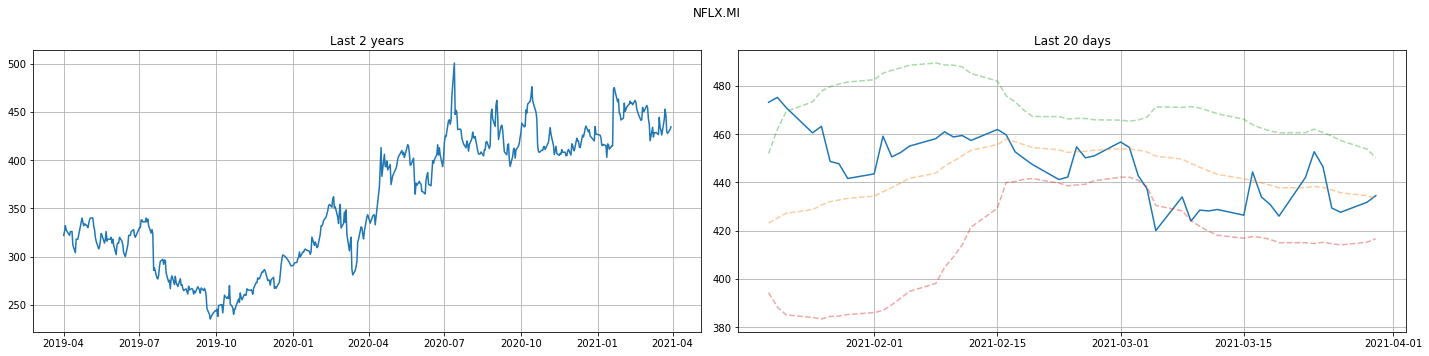

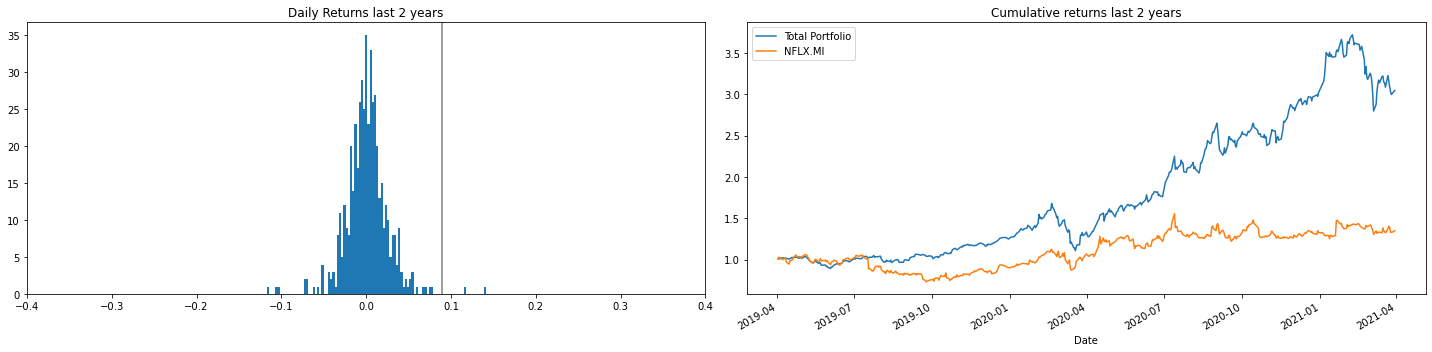

Relative to portfolio, last 400 days:

Correlation:  0.47939

Beta:  -0.04391   Alpha:  0.00317


Relative to portfolio, last 100 days:

Correlation:  0.33889

Beta:  -0.09416   Alpha:  0.00235

----------------------------------------------------------------



HUYA
Last Price: 19.4 


Mean Daily Return:  -0.01 %
Annualized Return:  -2.84 %

Mean Daily Return (last 20 days):  -1.63 %
Annualized Return (last 20 days):  -99.75 %


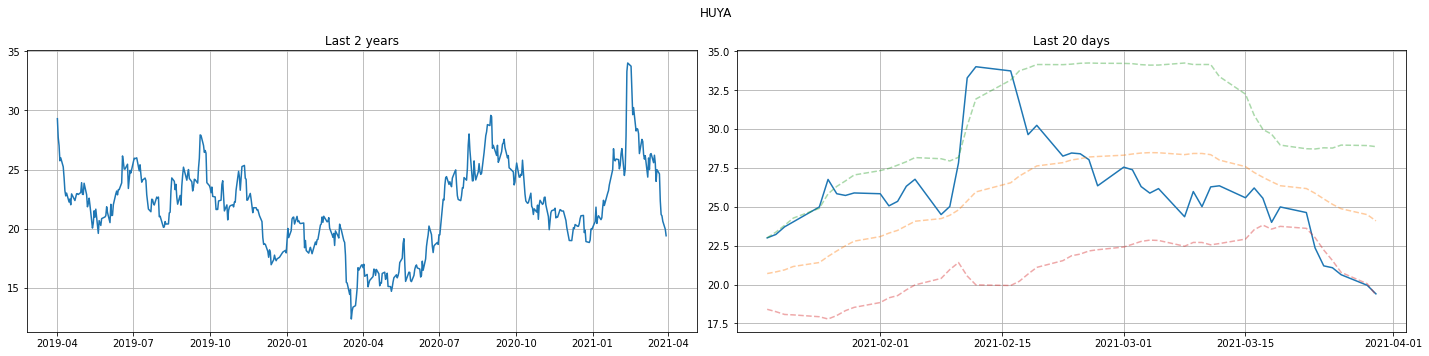

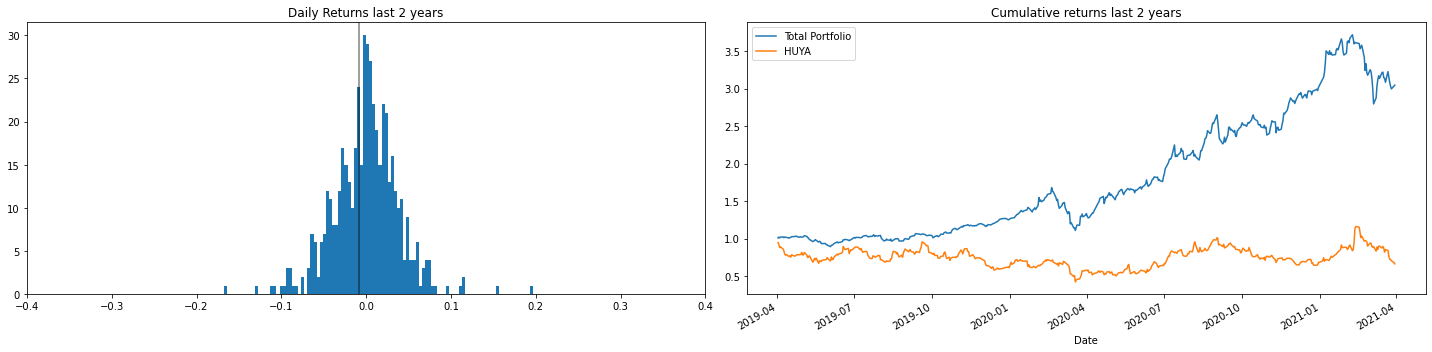

Relative to portfolio, last 400 days:

Correlation:  0.28562

Beta:  -0.02504   Alpha:  0.00311


Relative to portfolio, last 100 days:

Correlation:  0.1948

Beta:  0.01014   Alpha:  0.00231

----------------------------------------------------------------



ATVI
Last Price: 92.66 


Mean Daily Return:  0.16 %
Annualized Return:  79.45 %

Mean Daily Return (last 20 days):  -0.2 %
Annualized Return (last 20 days):  -51.46 %


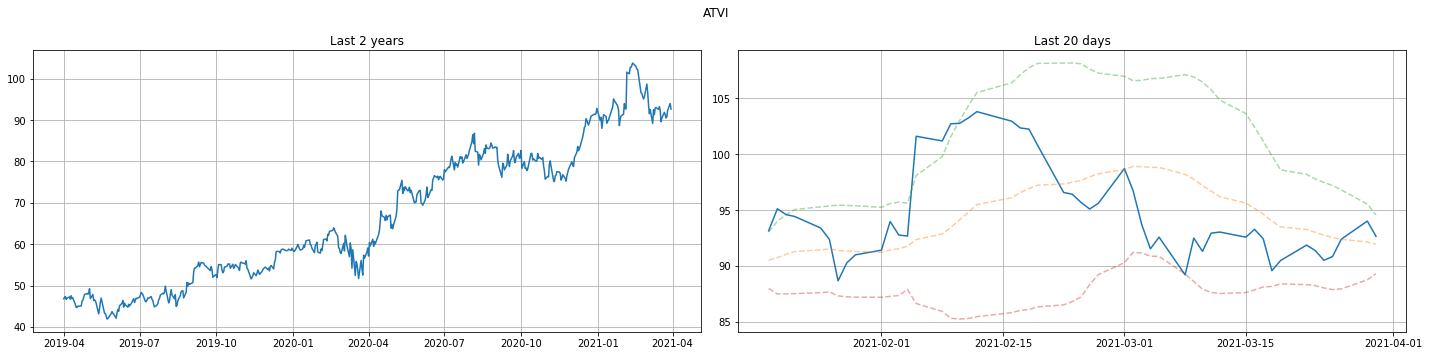

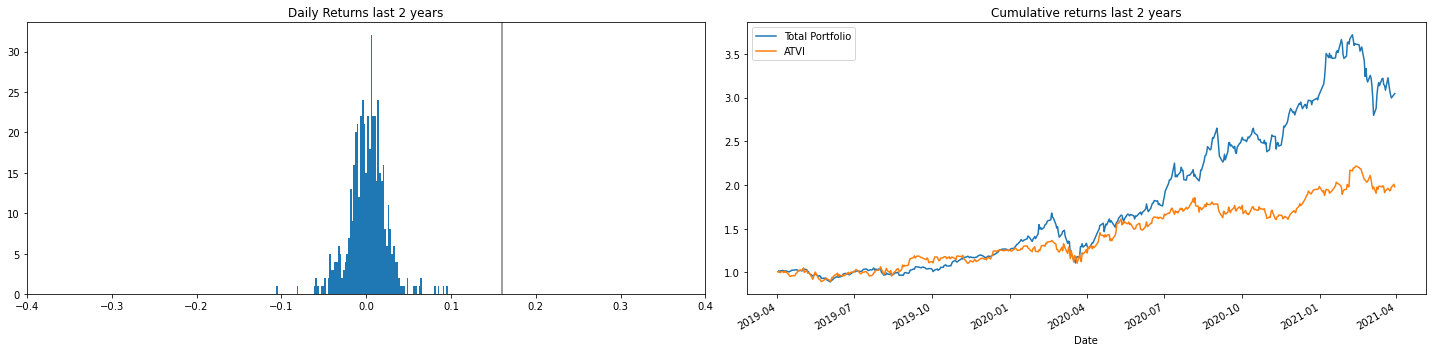

Relative to portfolio, last 400 days:

Correlation:  0.30597

Beta:  0.04588   Alpha:  0.00302


Relative to portfolio, last 100 days:

Correlation:  0.21851

Beta:  -0.06555   Alpha:  0.00245

----------------------------------------------------------------



CVS
Last Price: 76.08 


Mean Daily Return:  0.1 %
Annualized Return:  44.66 %

Mean Daily Return (last 20 days):  0.5 %
Annualized Return (last 20 days):  523.68 %


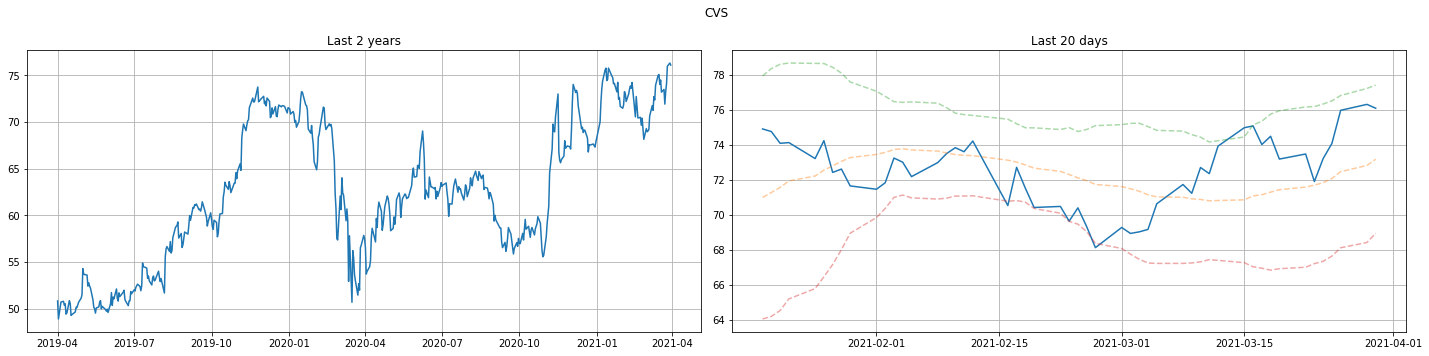

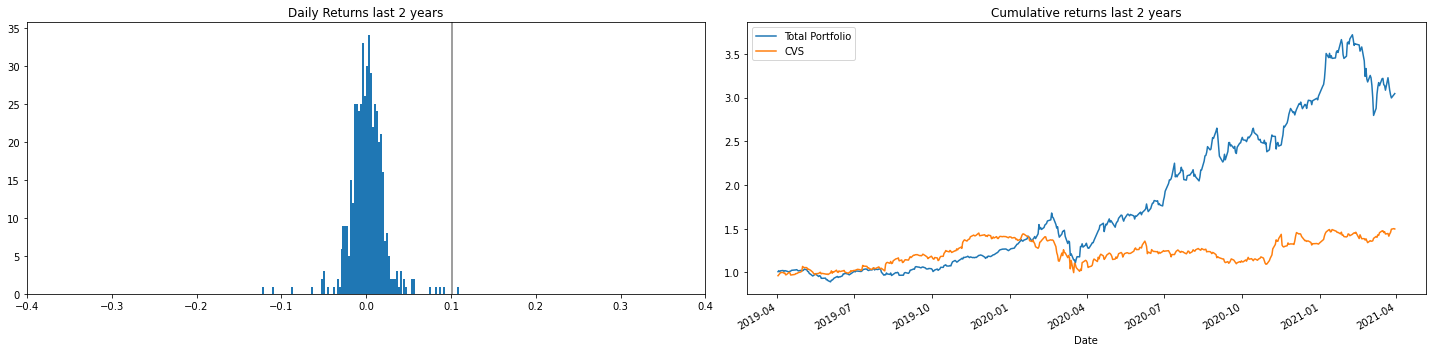

Relative to portfolio, last 400 days:

Correlation:  0.27744

Beta:  -0.06515   Alpha:  0.00316


Relative to portfolio, last 100 days:

Correlation:  -0.02228

Beta:  0.08481   Alpha:  0.00208

----------------------------------------------------------------



AAPL
Last Price: 119.9 


Mean Daily Return:  0.22 %
Annualized Return:  119.49 %

Mean Daily Return (last 20 days):  -0.19 %
Annualized Return (last 20 days):  -50.51 %


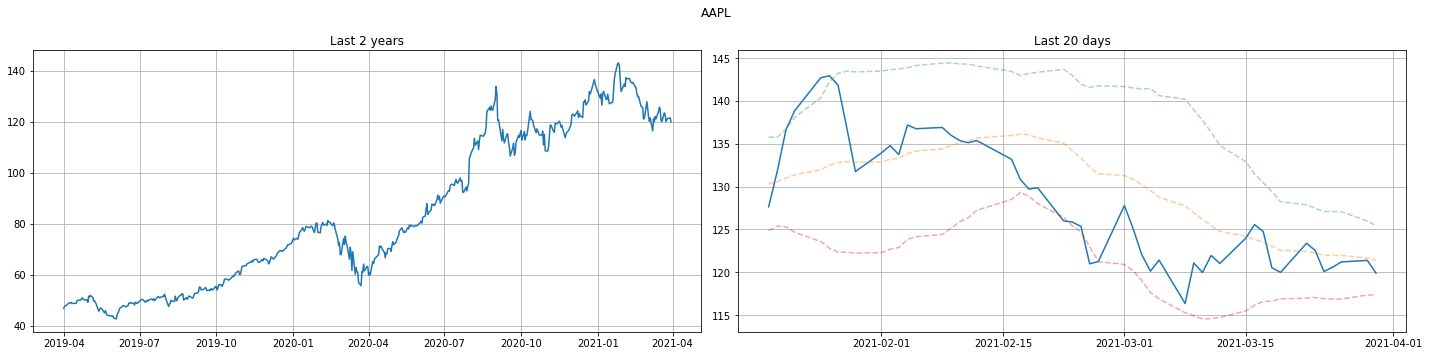

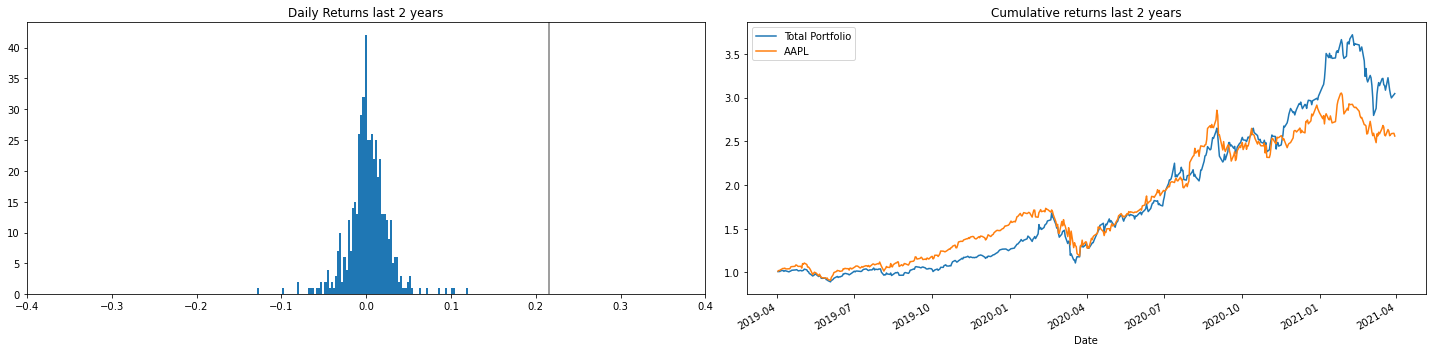

Relative to portfolio, last 400 days:

Correlation:  0.48695

Beta:  -0.01655   Alpha:  0.00314


Relative to portfolio, last 100 days:

Correlation:  0.30716

Beta:  0.05424   Alpha:  0.00225

----------------------------------------------------------------



NIO
Last Price: 37.55 


Mean Daily Return:  0.6 %
Annualized Return:  779.15 %

Mean Daily Return (last 20 days):  -0.51 %
Annualized Return (last 20 days):  -84.71 %


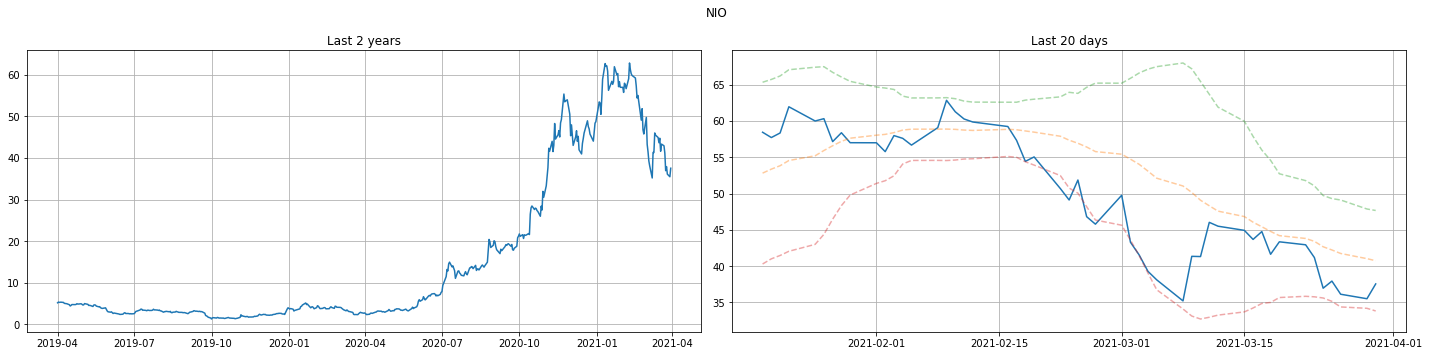

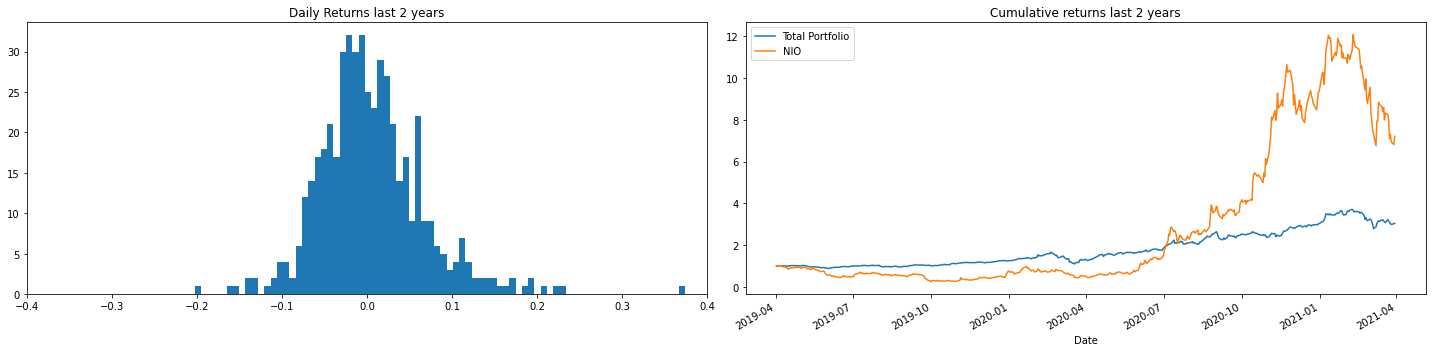

Relative to portfolio, last 400 days:

Correlation:  0.27708

Beta:  0.01354   Alpha:  0.00298


Relative to portfolio, last 100 days:

Correlation:  0.42138

Beta:  0.09297   Alpha:  0.00211

----------------------------------------------------------------



SQ
Last Price: 212.83 


Mean Daily Return:  0.28 %
Annualized Return:  176.66 %

Mean Daily Return (last 20 days):  -0.73 %
Annualized Return (last 20 days):  -93.1 %


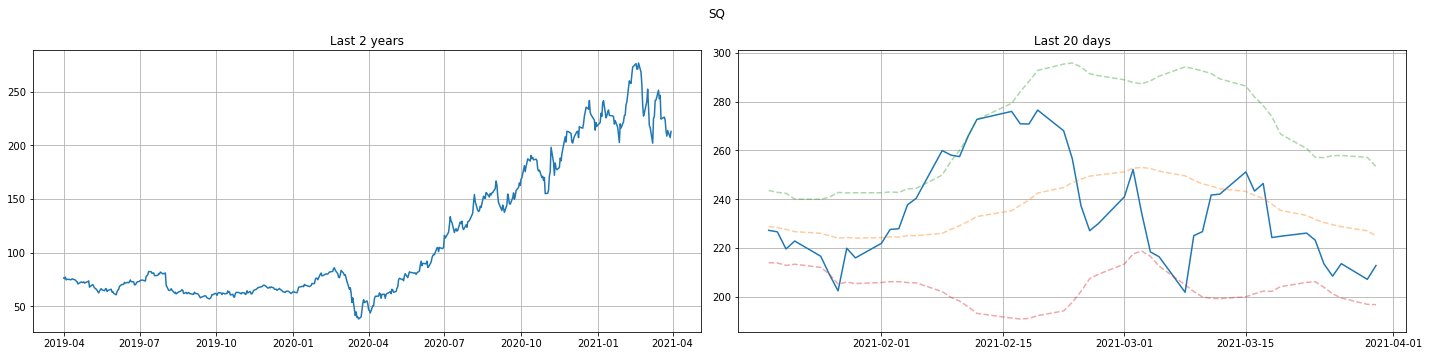

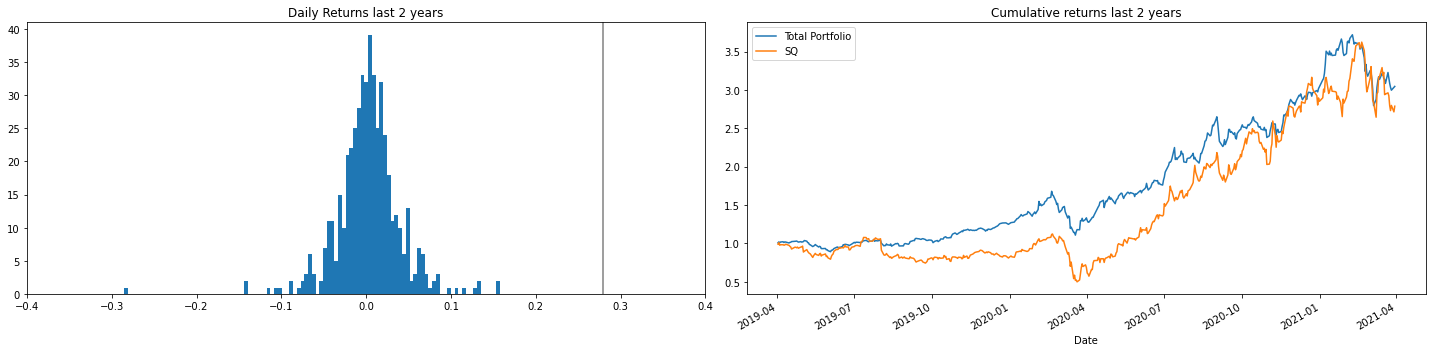

Relative to portfolio, last 400 days:

Correlation:  0.44

Beta:  0.00547   Alpha:  0.00308


Relative to portfolio, last 100 days:

Correlation:  0.33764

Beta:  0.09801   Alpha:  0.00194

----------------------------------------------------------------



PYPL
Last Price: 236.54 


Mean Daily Return:  0.2 %
Annualized Return:  106.12 %

Mean Daily Return (last 20 days):  -0.59 %
Annualized Return (last 20 days):  -88.41 %


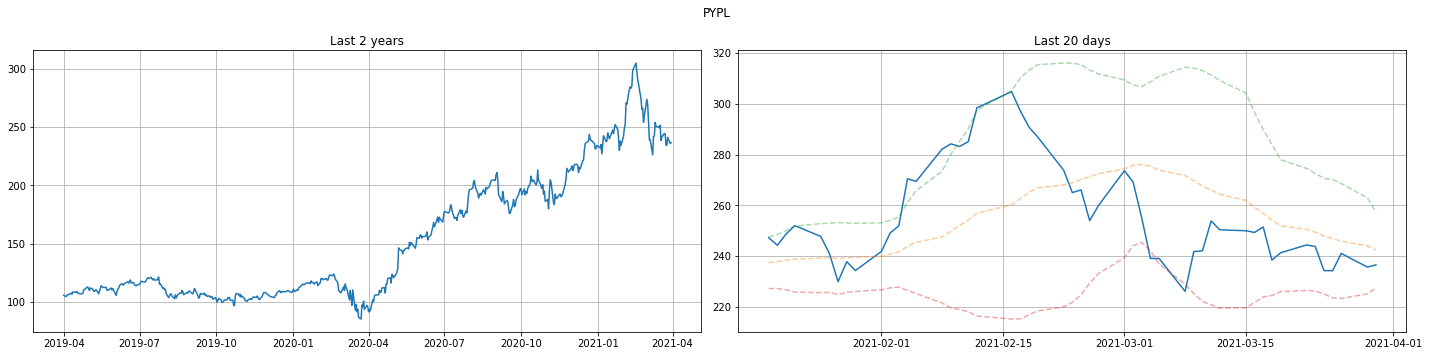

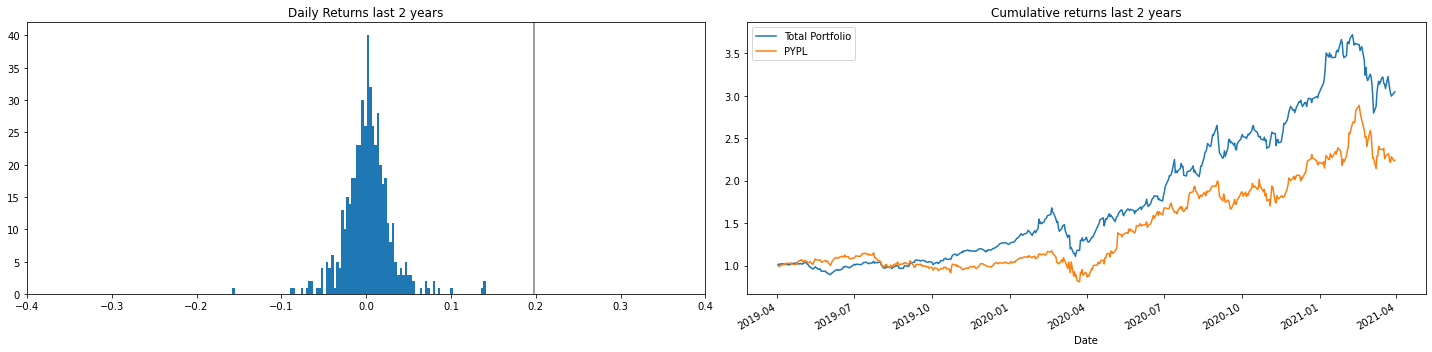

Relative to portfolio, last 400 days:

Correlation:  0.4237

Beta:  -0.0109   Alpha:  0.00313


Relative to portfolio, last 100 days:

Correlation:  0.33642

Beta:  0.08832   Alpha:  0.00203

----------------------------------------------------------------



ADBE
Last Price: 465.46 


Mean Daily Return:  0.14 %
Annualized Return:  64.29 %

Mean Daily Return (last 20 days):  0.01 %
Annualized Return (last 20 days):  5.59 %


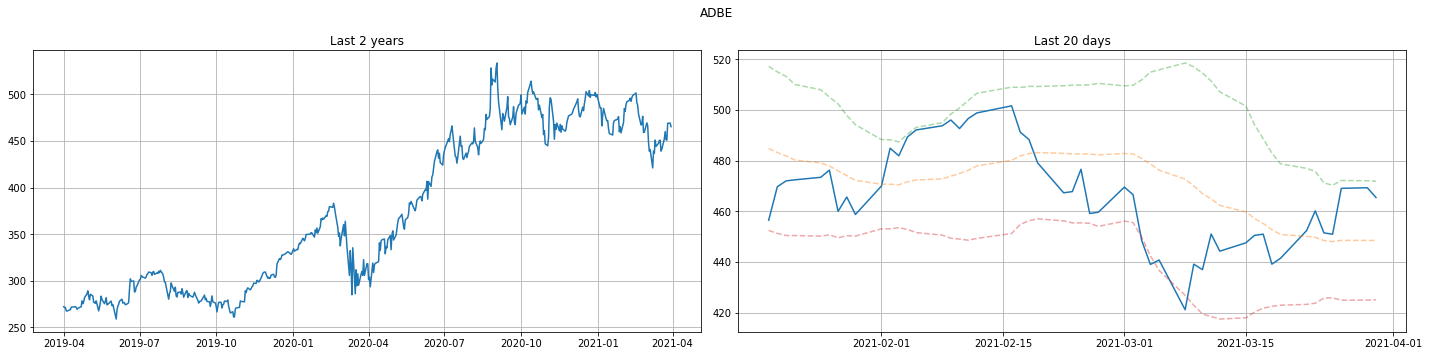

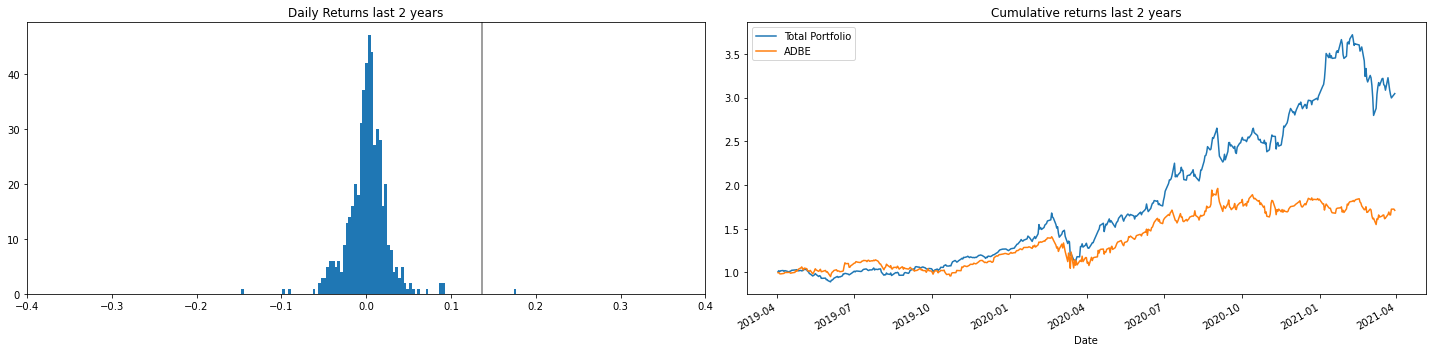

Relative to portfolio, last 400 days:

Correlation:  0.47174

Beta:  -0.00016   Alpha:  0.0031


Relative to portfolio, last 100 days:

Correlation:  0.37261

Beta:  -0.06986   Alpha:  0.00234

----------------------------------------------------------------



SND
Last Price: 2.51 


Mean Daily Return:  0.06 %
Annualized Return:  23.84 %

Mean Daily Return (last 20 days):  -1.69 %
Annualized Return (last 20 days):  -99.8 %


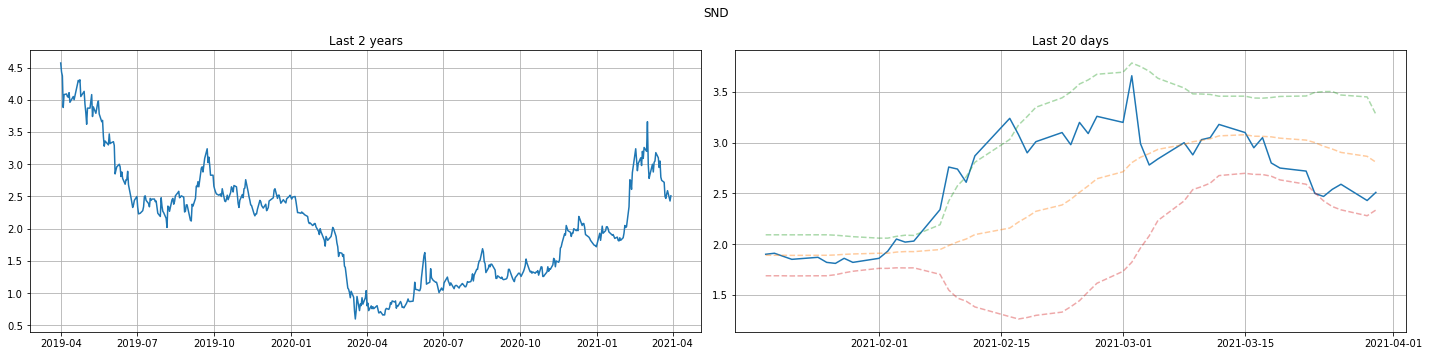

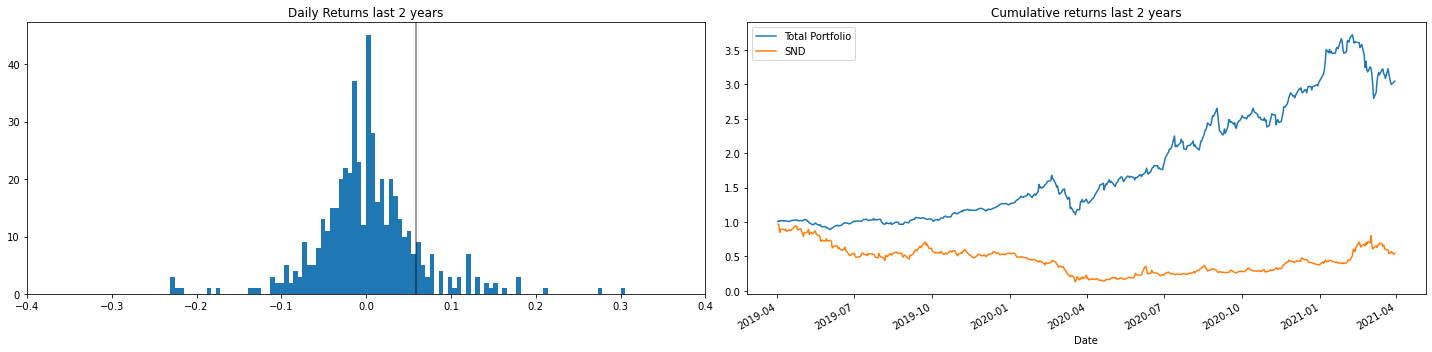

Relative to portfolio, last 400 days:

Correlation:  0.2165

Beta:  -0.04524   Alpha:  0.0032


Relative to portfolio, last 100 days:

Correlation:  0.0692

Beta:  0.0268   Alpha:  0.00211

----------------------------------------------------------------



SHOP
Last Price: 1048.68 


Mean Daily Return:  0.39 %
Annualized Return:  316.92 %

Mean Daily Return (last 20 days):  -1.04 %
Annualized Return (last 20 days):  -97.81 %


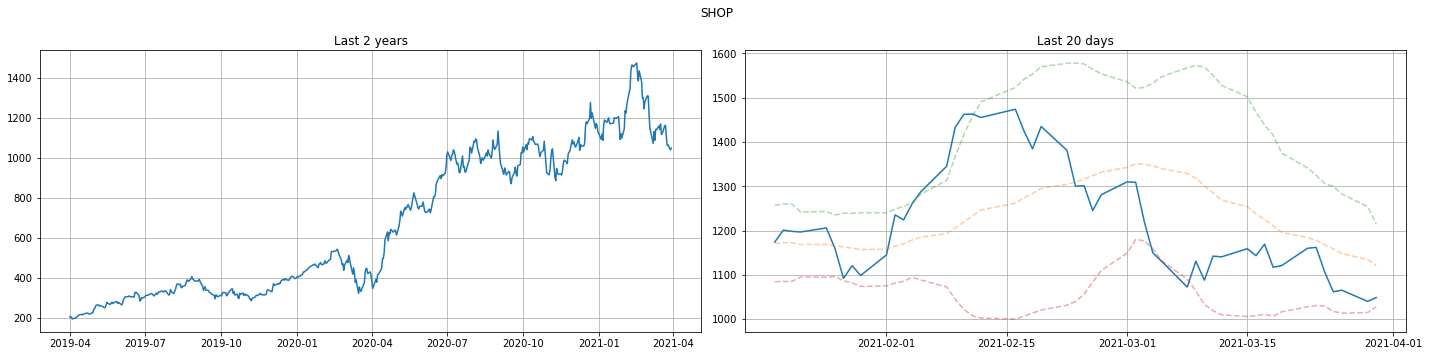

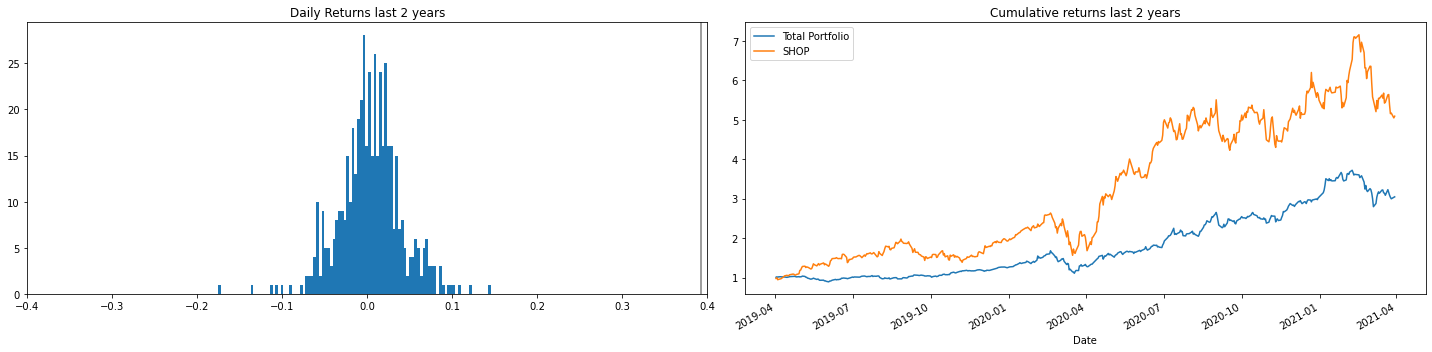

Relative to portfolio, last 400 days:

Correlation:  0.41816

Beta:  -0.00506   Alpha:  0.00312


Relative to portfolio, last 100 days:

Correlation:  0.30687

Beta:  0.06547   Alpha:  0.00219

----------------------------------------------------------------



MA
Last Price: 358.2 


Mean Daily Return:  0.11 %
Annualized Return:  50.44 %

Mean Daily Return (last 20 days):  -0.05 %
Annualized Return (last 20 days):  -16.28 %


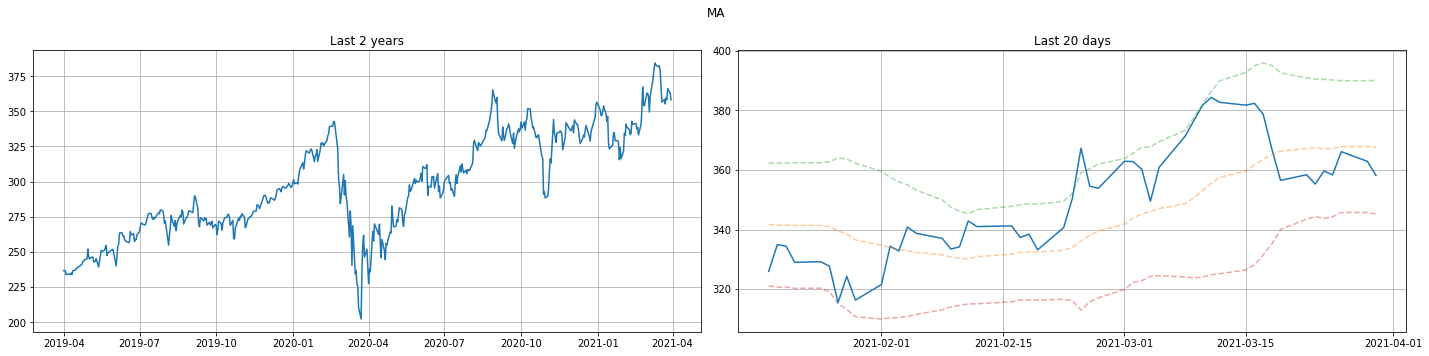

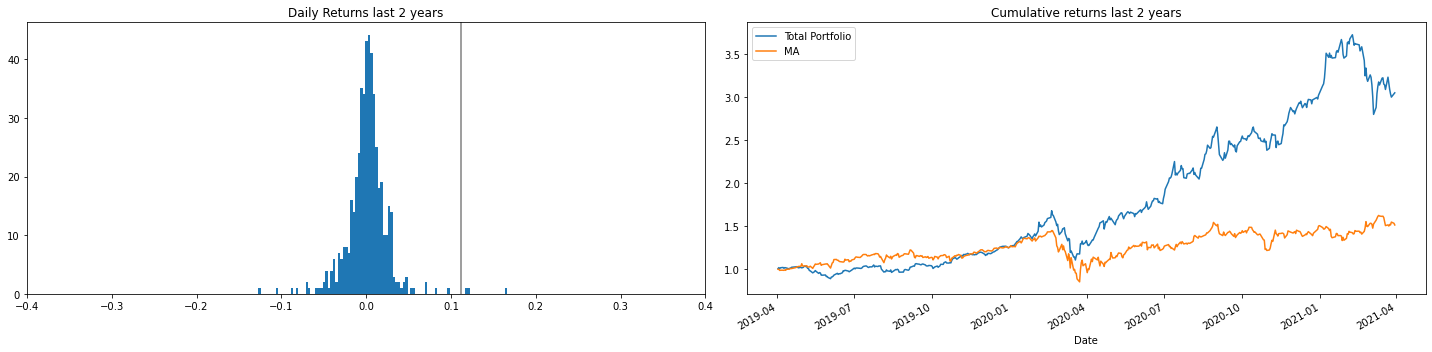

Relative to portfolio, last 400 days:

Correlation:  0.3971

Beta:  -0.08731   Alpha:  0.00319


Relative to portfolio, last 100 days:

Correlation:  0.18715

Beta:  -0.1845   Alpha:  0.00271

----------------------------------------------------------------



NTLA
Last Price: 72.24 


Mean Daily Return:  0.41 %
Annualized Return:  352.33 %

Mean Daily Return (last 20 days):  1.05 %
Annualized Return (last 20 days):  4361.53 %


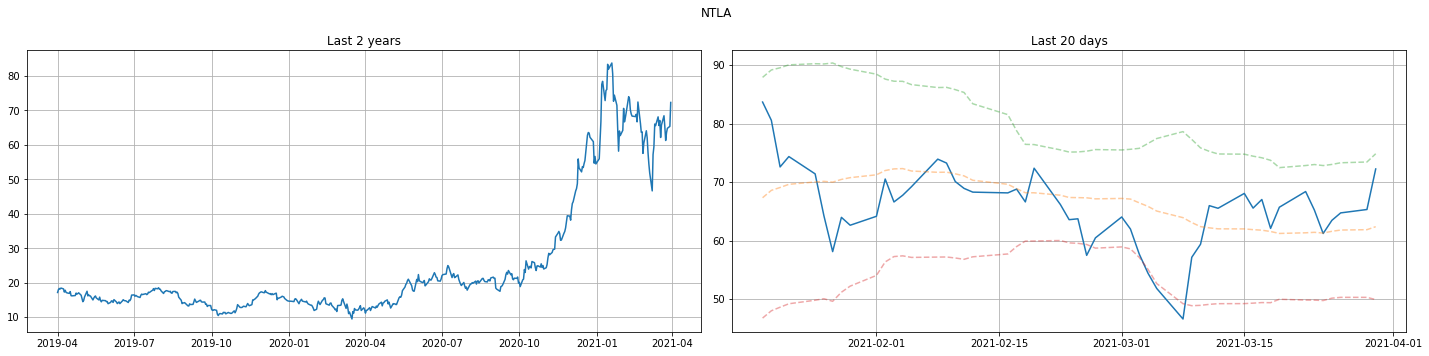

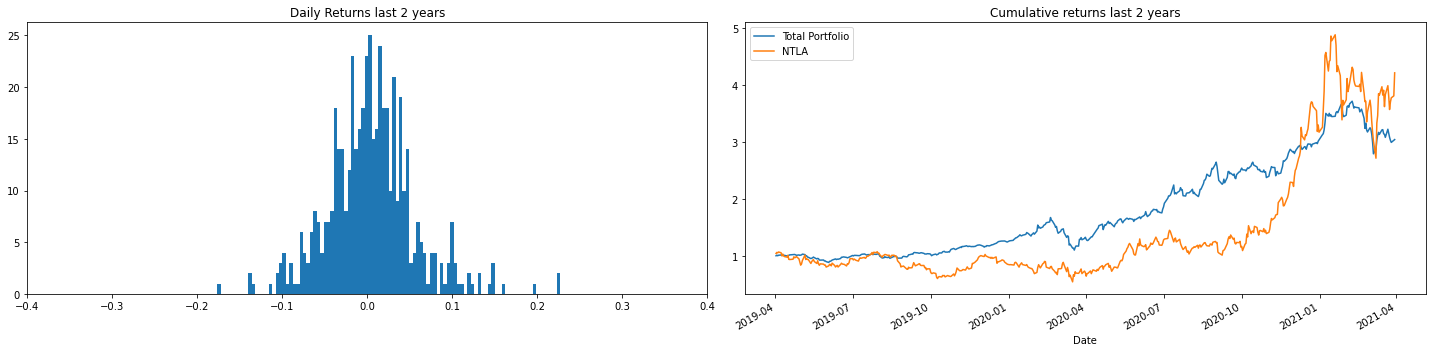

Relative to portfolio, last 400 days:

Correlation:  0.35866

Beta:  -0.01933   Alpha:  0.00321


Relative to portfolio, last 100 days:

Correlation:  0.34798

Beta:  0.02137   Alpha:  0.00204

----------------------------------------------------------------



CRSP
Last Price: 115.2 


Mean Daily Return:  0.32 %
Annualized Return:  215.58 %

Mean Daily Return (last 20 days):  -0.48 %
Annualized Return (last 20 days):  -82.8 %


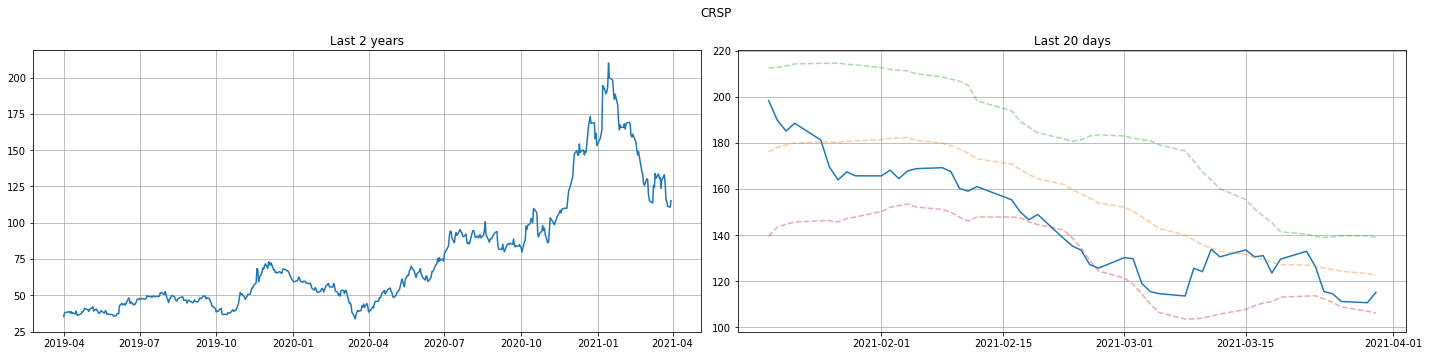

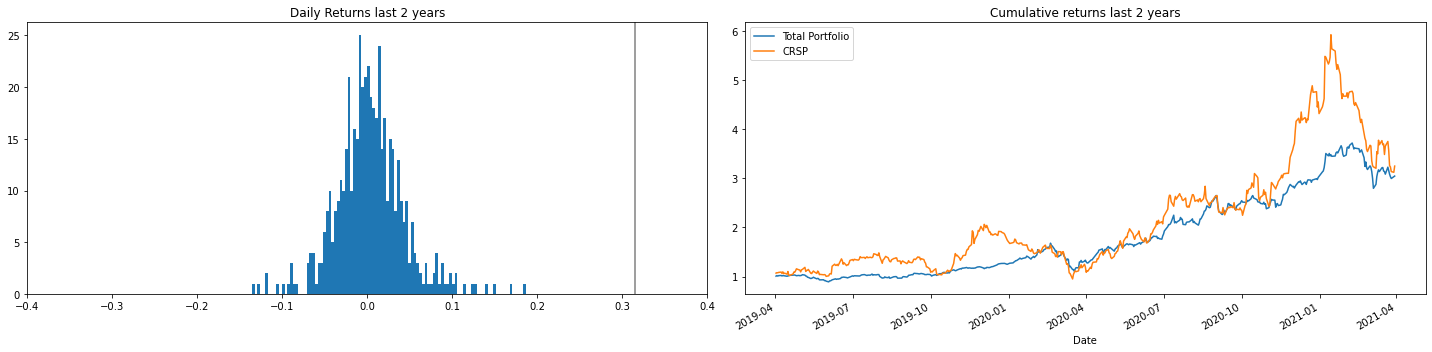

Relative to portfolio, last 400 days:

Correlation:  0.37249

Beta:  -0.02259   Alpha:  0.00317


Relative to portfolio, last 100 days:

Correlation:  0.42094

Beta:  0.02775   Alpha:  0.0022


In [14]:
#ANALYSIS OF NEW STOCKS

#data received through csv of yahoo finance
new_stocks_start = pd.read_csv(new_stocks_path)

#creating a list of tickers
my_new_ticks = list(new_stocks_start["Symbol"].unique())

#query to the Yahoo Finance API for all the stocks in the list 
#2 years, one value per day
new_stocks_df_list = [yf.download(tick, period = period, interval = interval) for tick in my_new_ticks]

#if our initial database doesn't include prices and quantity we automatically
#put the values to 1 to run the code
#try:
    #new_stocks_start["Purchase Price"]
#except KeyError:
    #new_stocks_start["Purchase Price"] = [1]*new_stocks_start.shape[0]
#
#try:
    #new_stocks_start["Quantity"]
#except KeyError:
    #new_stocks_start["Quantity"] = [1]*new_stocks.shape[0]

#individual stocks new variables
for i in range(len(my_new_ticks)):
    new_stocks_df_list[i]["Daily Returns"] = (new_stocks_df_list[i]["Adj Close"]/new_stocks_df_list[i]["Adj Close"].shift(1))-1
    new_stocks_df_list[i]["Cumulative Daily Return"] = (1+ new_stocks_df_list[i]["Daily Returns"]).cumprod()
    new_stocks_df_list[i]["20 day mean"] = new_stocks_df_list[i]["Adj Close"].rolling(20).mean()
    new_stocks_df_list[i]["Upper"] = new_stocks_df_list[i]["20 day mean"] + 2*(new_stocks_df_list[i]["Adj Close"].rolling(20).std())
    new_stocks_df_list[i]["Lower"] = new_stocks_df_list[i]["20 day mean"] - 2*(new_stocks_df_list[i]["Adj Close"].rolling(20).std())

    
new_ticks_corr_400_list = []
new_ticks_beta_400_list = []
new_ticks_alpha_400_list = []
new_ticks_corr_100_list = []
new_ticks_beta_100_list = []
cumulative_return_ticks = []
for i in range(len(my_new_ticks)):
    
    print("\n----------------------------------------------------------------\n")
    print("\n\n"+'\033[1m'+'\033[94m' + my_new_ticks[i] +'\033[0m')
    last_price =  new_stocks_df_list[i].tail(1)["Adj Close"]
    mean_return = new_stocks_df_list[i]["Daily Returns"].dropna().mean()*100
    annualized_return = ((((mean_return/100)+1)**365)-1)*100
    mean_return_last20days = new_stocks_df_list[i]["Daily Returns"].dropna().tail(20).mean()*100
    annualized_return_last20days = ((((mean_return_last20days/100)+1)**365)-1)*100
    
    print('\033[1m'+'\033[94m'"Last Price:", round(float(last_price),3), '\033[0m'+"\n\n")
    #show various indexes on the returns
    print('\033[1m' +"Mean Daily Return: "'\033[0m',
          round(mean_return,2),"%",) 
    print('\033[1m' +"Annualized Return: "'\033[0m',
          round(annualized_return,2),"%") 
    print('\033[1m' +"\nMean Daily Return (last 20 days): "'\033[0m',
          round(mean_return_last20days,2),"%",) 
    print('\033[1m' +"Annualized Return (last 20 days): "'\033[0m',
          round(annualized_return_last20days,2),"%") 
    
    #plotted overall value over whole periods
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,5))
    fig.suptitle(my_new_ticks[i])
    ax1.grid()
    ax1.plot(new_stocks_df_list[i].index, new_stocks_df_list[i]["Adj Close"])
    ax1.set_title("Last 2 years")
    
    #plot of the stock price for the last 20 days 
    #togheter with the 50 days floating mean, upper and lower limit
    #shown a line with the purchase price
    ax2.grid()
    ax2.plot(new_stocks_df_list[i].tail(50).index, new_stocks_df_list[i]["Adj Close"].tail(50), alpha = 1)
    ax2.plot(new_stocks_df_list[i].tail(50).index, new_stocks_df_list[i][["20 day mean", "Upper", "Lower"]].tail(50), alpha = (.4), linestyle = "--")
    ax2.set_title("Last 20 days")
    fig.tight_layout()
    plt.show()
    
    #plot distribution of daily returns 
    mean_return = new_stocks_df_list[i]["Daily Returns"].dropna().mean()*100
    fig, (ax21, ax22) = plt.subplots(1, 2,figsize=(20,5))
    ax21.hist(new_stocks_df_list[i]["Daily Returns"].dropna(), bins = 100)
    ax21.axvline(x= mean_return,color='black', linestyle="-", alpha=.5 )
    ax21.set_title("Daily Returns last 2 years")
    ax21.set_xlim(-0.4,+0.4)
    
    #plot cumulative daily return
    ax22.grid()
    ax22 = portfolio_df["Cumulative Daily Return"].plot()
    ax22 = new_stocks_df_list[i]["Cumulative Daily Return"].plot()
    ax22.legend(["Total Portfolio", my_new_ticks[i]])
    ax22.set_title("Cumulative returns last 2 years")
    fig.tight_layout()
    plt.show()
    
    plt.show()
    
    
    try:
        #regression portfolio on index last 400 days
        new_ticks_beta_400, new_ticks_alpha_400, new_ticks_r_value_400, new_ticks_p_value_400, new_ticks_std_err_400 = stats.linregress(new_stocks_df_list[i]["Daily Returns"].dropna().tail(400),portfolio_df["Daily Returns"].dropna().tail(400))
        
        #correlation between portfolio and index last 400 days
        new_ticks_corr_400 = portfolio_df["Daily Returns"].dropna().tail(400).corr(new_stocks_df_list[i]["Daily Returns"].dropna().tail(400))
    except:
        new_ticks_corr_400 = 0
        new_ticks_beta_400 = 0
        new_ticks_alpha_400 = 0
        print("\nno data for last 400 days") 
        
    #show beta and alpha from the regression last 400 days
    print("Relative to portfolio, last 400 days:")
    print('\033[1m' + "\nCorrelation: "'\033[0m', round(new_ticks_corr_400, 5))
    print('\033[1m' + "\nBeta: "'\033[0m', round(new_ticks_beta_400, 5), end= "   ")
    print('\033[1m' + "Alpha: "'\033[0m', round(new_ticks_alpha_400,5))
    
    try:
        #regression portfolio on index last 100 days
        new_ticks_beta_100, new_ticks_alpha_100, new_ticks_r_value_100, new_ticks_p_value_100, new_ticks_std_err_100 = stats.linregress(new_stocks_df_list[i]["Daily Returns"].dropna().tail(100),portfolio_df["Daily Returns"].dropna().tail(100))
        
        #correlation between portfolio and index last 100 days
        new_ticks_corr_100 = portfolio_df["Daily Returns"].dropna().tail(100).corr(new_stocks_df_list[i]["Daily Returns"].dropna().tail(100))
    except:
        try:
            #regression portfolio on index last 100 days
            new_ticks_beta_100, new_ticks_alpha_100, new_ticks_r_value_100, new_ticks_p_value_100, new_ticks_std_err_100 = stats.linregress(new_stocks_df_list[i]["Daily Returns"].dropna().tail(50),portfolio_df["Daily Returns"].dropna().tail(50))
            
            #correlation between portfolio and index last 100 days
            new_ticks_corr_100 = portfolio_df["Daily Returns"].dropna().tail(500).corr(new_stocks_df_list[i]["Daily Returns"].dropna().tail(50))
            print("no data for last 100 days, 50 days instead")
        except:
            new_ticks_corr_100 = 0
            new_ticks_beta_100 = 0
            new_ticks_alpha_100 = 0
            print("\nno data for last 100, not 50 days") 
    
    #show beta and alpha from the regression last 400 days
    print("\n\nRelative to portfolio, last 100 days:")
    print('\033[1m' + "\nCorrelation: "'\033[0m', round(new_ticks_corr_100, 5))
    print('\033[1m' + "\nBeta: "'\033[0m', round(new_ticks_beta_100, 5), end= "   ")
    print('\033[1m' + "Alpha: "'\033[0m', round(new_ticks_alpha_100,5))
    
    #appending the values
    new_ticks_corr_400_list.append(new_ticks_corr_400)
    new_ticks_beta_400_list.append(new_ticks_beta_400)
    new_ticks_alpha_400_list.append(new_ticks_alpha_400)
    new_ticks_corr_100_list.append(new_ticks_corr_100)
    new_ticks_beta_100_list.append(new_ticks_beta_100)
    cumulative_return_ticks.append(float(new_stocks_df_list[i]["Cumulative Daily Return"].tail(1)))
    


#a table for fast comparison across indexes
new_ticks_table = pd.DataFrame(list(zip(my_new_ticks,cumulative_return_ticks, new_ticks_corr_400_list, new_ticks_beta_400_list, 
                           new_ticks_alpha_400_list, new_ticks_corr_100_list, new_ticks_beta_100_list)),
                  columns =["Ticker", "Cumulative Daily Return", "corr_400", "beta_400", "alpha_400",
                           "corr_100", "beta_100"])

#color formatting to aid the comparison
display(new_ticks_table.style.\
       hide_index().\
       background_gradient(cmap='RdYlGn',subset= ["Cumulative Daily Return","corr_400", "beta_400", "alpha_400",
                           "corr_100", "beta_100"]))

In [15]:
#SHARPE RATIO OPTIMIZATION with new stocks (custom) [1]
#Variables for custom optimization
print("""If "optimal", optimization on Sharpe Ratio.
If "volatility", optimization with volatility max (select max volatility).""")
print("Select how much % of the portfolio for each stock can be allocated")
print("Select how many days in the past consider for the analysis.")


radiobuttons1 = widgets.RadioButtons(
    value='optimal', 
    options=['optimal', 'volatility'], 
    description='Parameters'
)

int_slider1 = widgets.IntSlider(
    value=30, 
    min=0, max=50, step=1, 
    description='Max volatility %'
)




int_slider2 = widgets.IntSlider(
    value=200, 
    min=0, max=500, step=1, 
    description='Days'
)

int_slider3 = widgets.IntSlider(
    value=60, 
    min=0, max=100, step=1, 
    description='Max % per stock'
)

widgets.VBox(
    [
        radiobuttons1,
        int_slider1, 
        int_slider3,
        int_slider2

    ]
)

If "optimal", optimization on Sharpe Ratio.
If "volatility", optimization with volatility max (select max volatility).
Select how much % of the portfolio for each stock can be allocated
Select how many days in the past consider for the analysis.


Sharpe Ratio optimization, last 200 days


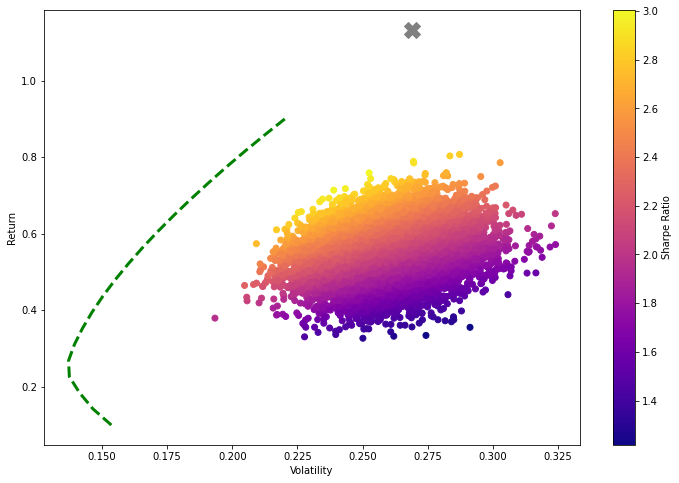



Optimization results 

Return : 1.1329361357413295
Volatility : 0.2687597931223449
Sharpe Ratio : 4.215422711036223

 SNE 
Actual:  0.07      Optimal:  0.1

 TME 
Actual:  0.04      Optimal:  0.04

 TSLA.MI 
Actual:  0.13      Optimal:  0.11

 ERCB.DE 
Actual:  0.04      Optimal:  0.04

 RICK 
Actual:  0      Optimal:  0.12

 DAI.DE 
Actual:  0      Optimal:  0.37

 ROKU 
Actual:  0      Optimal:  0.08

 NIO 
Actual:  0      Optimal:  0.07

 SQ 
Actual:  0      Optimal:  0.06

 NTLA 
Actual:  0      Optimal:  0.01


In [16]:
#SHARPE RATIO OPTIMIZATION with new stocks(custom) [2]

#let's build a fake new portfolio = old + new stocks
new_portfolio = portfolio_df[my_ticks]
#IF I WANT TO CHANGE THE LIST: DEFINE A CUSTOM LIST HERE! 
#note: it should be a subset of the previous new stock analysis
list_tick_to_add = my_new_ticks
all_ticks = my_ticks + list_tick_to_add

#add new stock through a for loop
for tick in list_tick_to_add:
    position = my_new_ticks.index(tick)
    new_portfolio[tick] = new_stocks_df_list[position]["Adj Close"]

#put together all the adj. close for every stock
stocks = new_portfolio.tail(days)


opt_or_vol = radiobuttons1.value
days = int_slider2.value
max_volatility = int_slider1.value/100
max_per_stock = int_slider3.value/100



print(f"Sharpe Ratio optimization, last {days} days")
log_ret= np.log(stocks/stocks.shift(1))

num_ports = 10000
all_weights = np.zeros((num_ports, len(stocks.columns)))
ret_arr = np.zeros(num_ports)
vol_arr = np.zeros(num_ports)
sharpe_arr = np.zeros(num_ports)

for ind in range(num_ports):
    weights = np.array(np.random.random(len(stocks.columns)))
    weights = weights/np.sum(weights)
    all_weights[ind,:] = weights
    ret_arr[ind]=  np.sum((log_ret.mean()*weights)*252)
    vol_arr[ind] = np.sqrt(np.dot(weights.T,np.dot(log_ret.cov()*252,weights)))
    sharpe_arr[ind] = ret_arr[ind]/vol_arr[ind]


def get_ret_vol_sr(weights):
    """
    Takes in weights, returns array or return,volatility, sharpe ratio
    """
    weights = np.array(weights)
    ret = np.sum(log_ret.mean() * weights) * 252
    vol = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov() * 252, weights)))
    sr = ret/vol
    return np.array([ret,vol,sr])

def neg_sharpe(weights):
    return  get_ret_vol_sr(weights)[2] * -1

# Contraints
def check_sum(weights):

    return np.sum(weights) - 1

cons = ({'type':'eq','fun': check_sum})
# 0-1 bounds for each weight
bounds = ((0, max_per_stock),)*len(stocks.columns)
init_guess = list(np.repeat(1/len(stocks.columns), len(stocks.columns)))
opt_results = minimize(neg_sharpe,init_guess,method='SLSQP',bounds=bounds,constraints=cons)

# Create a linspace number of points to calculate x on
frontier_y = np.linspace(0.1,0.9,20) 
def minimize_volatility(weights):
    return  get_ret_vol_sr(weights)[1] 
frontier_volatility = []

for possible_return in frontier_y:
    # function for return
    cons = ({'type':'eq','fun': check_sum},
            {'type':'eq','fun': lambda w: get_ret_vol_sr(w)[0] - possible_return})
    
    result = minimize(minimize_volatility,init_guess,method='SLSQP',bounds=bounds,constraints=cons)
    
    frontier_volatility.append(result['fun'])

opt_results.x
opt_values = get_ret_vol_sr(opt_results.x)
    
plt.figure(figsize=(12,8))
plt.scatter(vol_arr,ret_arr,c=sharpe_arr,cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')

# Add frontier line
plt.plot(frontier_volatility,frontier_y,'g--',linewidth=3)
plt.plot(opt_values[1],opt_values[0],'X', color = "grey", markersize=16) 
plt.show()


if opt_or_vol == "optimal":
    
    print('\033[1m' +"\n\nOptimization results \n"'\033[0m')
    print('\033[1m' +"Return :"'\033[0m',opt_values[0])
    print('\033[1m' +"Volatility :"'\033[0m',opt_values[1])
    print('\033[1m' +"Sharpe Ratio :"'\033[0m',opt_values[2])
    
    for i in range(len(all_ticks)):
        if round(opt_results.x[i],3) == 0:
            continue
        else:
            if i < len(my_ticks):
                print("\n",'\033[1m'+all_ticks[i]+'\033[0m',"\nActual: ",round(portfolio.loc[i,"% of allocation"],2),"     Optimal: ",round(opt_results.x[i],2))
            else:
                print("\n",'\033[1m'+all_ticks[i]+'\033[0m',"\nActual: ",0,"     Optimal: ",round(opt_results.x[i],2))
            
elif opt_or_vol == "volatility":
        
    cons = ({'type':'eq','fun': check_sum},
            {'type':'eq','fun': lambda w: get_ret_vol_sr(w)[1] - max_volatility})
    vol_result = minimize(neg_sharpe,init_guess,method='SLSQP',bounds=bounds,constraints=cons)
    vol_values = get_ret_vol_sr(vol_result.x)
    
    print('\033[1m' +"\n\nOptimization results \n"'\033[0m')
    print('\033[1m' +"Return :"'\033[0m',vol_values[0])
    print('\033[1m' +"Volatility :"'\033[0m',vol_values[1])
    print('\033[1m' +"Sharpe Ratio :"'\033[0m',vol_values[2])
    
    for i in range(len(all_ticks)):
        if round(opt_results.x[i],3) == 0:
            continue
        else:
            if i < len(my_ticks):
                print("\n",'\033[1m'+all_ticks[i]+'\033[0m',"\nActual: ",round(portfolio.loc[i,"% of allocation"],3),"     Optimal: ",round(opt_results.x[i],3))
            else:
                print("\n",'\033[1m'+all_ticks[i]+'\033[0m',"\nActual: ",0,"     Optimal: ",round(opt_results.x[i],3))
    
    
else:
    print("error")